In [ ]:
import glob
import os
import re
import sys
from collections import defaultdict
from functools import reduce, partial
from multiprocessing import Pool

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from pymutspec.annotation.spectra import get_cossim, complete_sbs192_columns, collapse_sbs192
from pymutspec.annotation import CodonAnnotation, rev_comp
from pymutspec.constants import possible_sbs192, possible_sbs12
from pymutspec.draw import plot_mutspec192, plot_mutspec12
import pymutspec

from Bio import SeqIO
from Bio.Data import CodonTable
from scipy import spatial

import warnings
warnings.filterwarnings("ignore")

coda = CodonAnnotation(gencode=2)

### Spectrum QC

In [ ]:
sp12 = pd.read_csv('../data/chordata2/spectra12.csv', index_col=0).fillna(0.)
sp192 = pd.read_csv('../data/chordata2/spectra192.csv', index_col=0).fillna(0.)
sp12.columns.rename('Mut', inplace=True)
sp192.columns.rename('Mut', inplace=True)

In [ ]:
sp12

Mut,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
gene__species,,,,,,,,,,,,
A6__Acanthurus_nigricans,0.000000,0.123837,0.000000,0.050548,0.000000,0.115756,0.502990,0.000000,0.000000,0.000000,0.114915,0.091955
A6__Acanthurus_triostegus,0.033073,0.105169,0.000000,0.000000,0.000000,0.227589,0.226789,0.139521,0.000000,0.000000,0.267859,0.000000
A6__Adelomyia_melanogenys,0.000000,0.063601,0.011970,0.012403,0.009329,0.096497,0.343220,0.087778,0.029950,0.022638,0.307504,0.015110
A6__Agkistrodon_contortrix,0.026959,0.048391,0.013533,0.029567,0.000000,0.112196,0.506789,0.000000,0.000000,0.000000,0.262566,0.000000
A6__Agkistrodon_piscivorus,0.018371,0.082840,0.000000,0.000000,0.000000,0.081009,0.613605,0.000000,0.000000,0.042154,0.162022,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
ND6__Vidua_purpurascens,0.000000,0.223506,0.000000,0.000000,0.000000,0.472941,0.068330,0.000000,0.085255,0.000000,0.149968,0.000000
ND6__Vireo_olivaceus,0.000000,0.454823,0.000000,0.000000,0.000000,0.395078,0.031969,0.000000,0.018524,0.000000,0.099607,0.000000
ND6__Vireo_solitarius,0.000000,0.170569,0.000000,0.000000,0.000000,0.448220,0.097904,0.000000,0.076775,0.000000,0.206532,0.000000


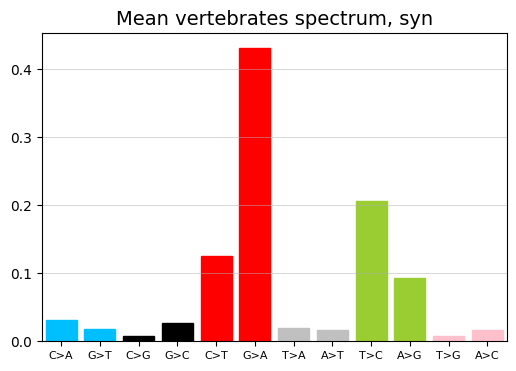

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


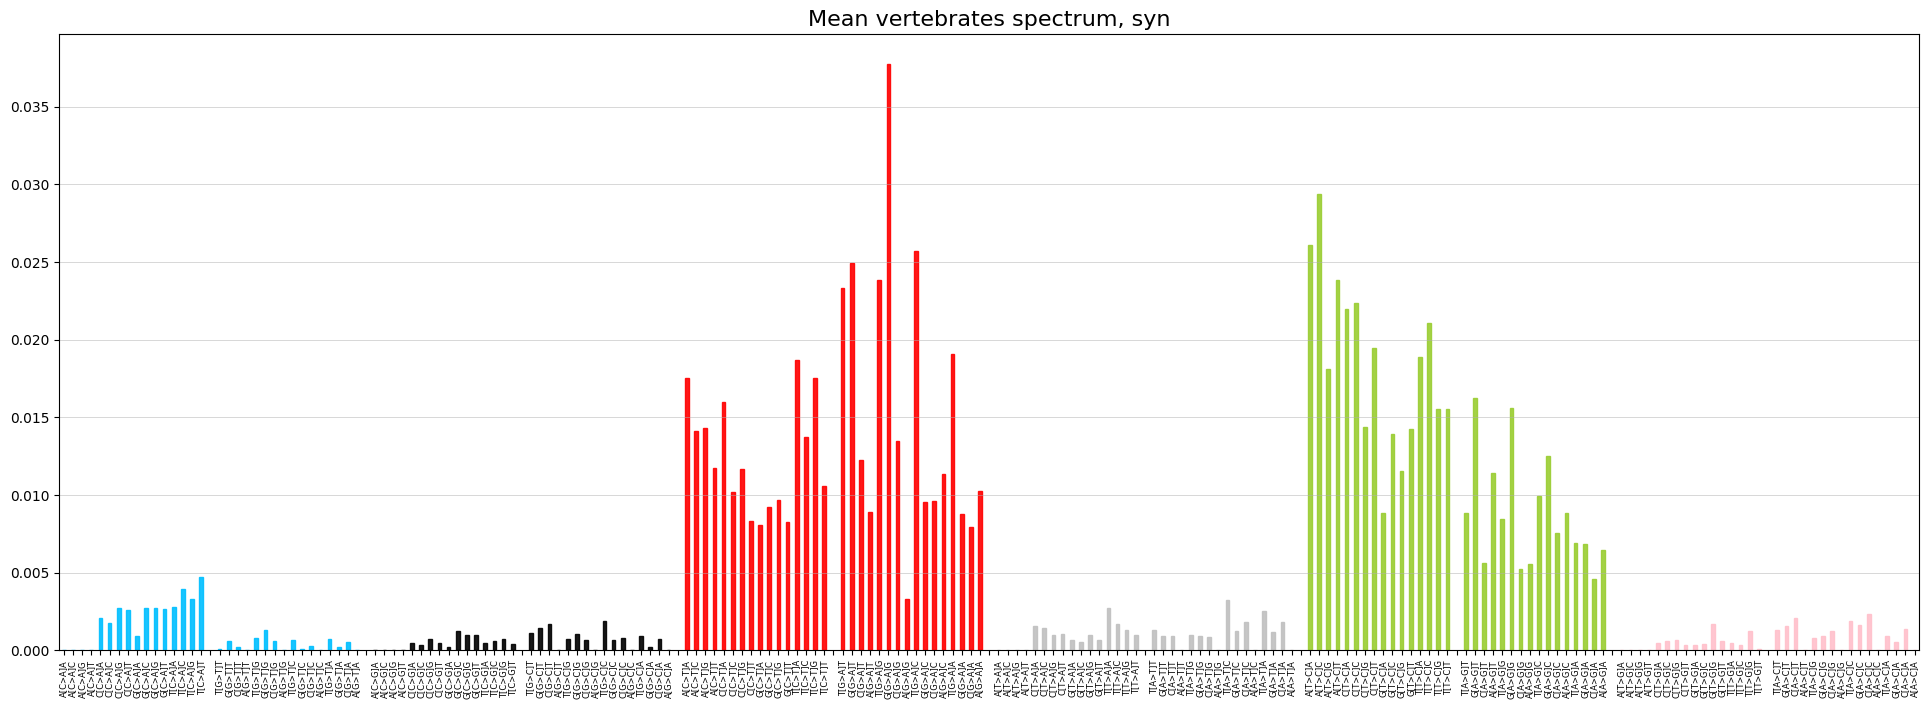

In [ ]:
plot_mutspec12(sp12[sp12.index.str.startswith('Cytb')].mean(axis=0).rename('MutSpec').reset_index(), title='Mean vertebrates spectrum, syn');
plot_mutspec192(sp192[sp192.index.str.startswith('Cytb')].fillna(0.).mean(axis=0).rename('MutSpec').reset_index(), title='Mean vertebrates spectrum, syn');

### PCA

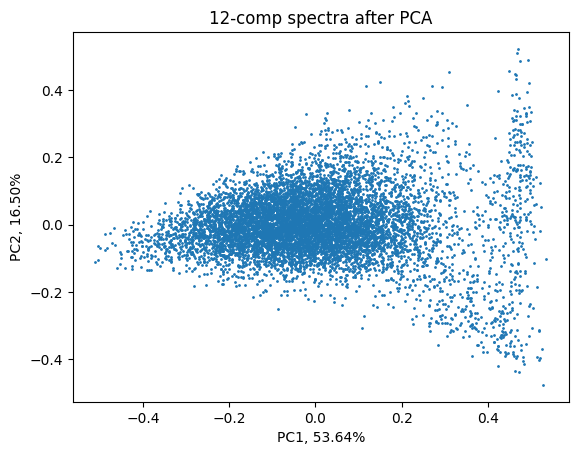

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X = sp12.fillna(0.)
n_components = 2  # Specify the number of dimensions you want to reduce to
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

# Plot the reduced dimensions
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=1)  # Modify according to your number of components
plt.xlabel(f'PC1, {pca.explained_variance_ratio_[0]*100:.2f}%')
plt.ylabel(f'PC2, {pca.explained_variance_ratio_[1]*100:.2f}%')
plt.title('12-comp spectra after PCA')
plt.show()

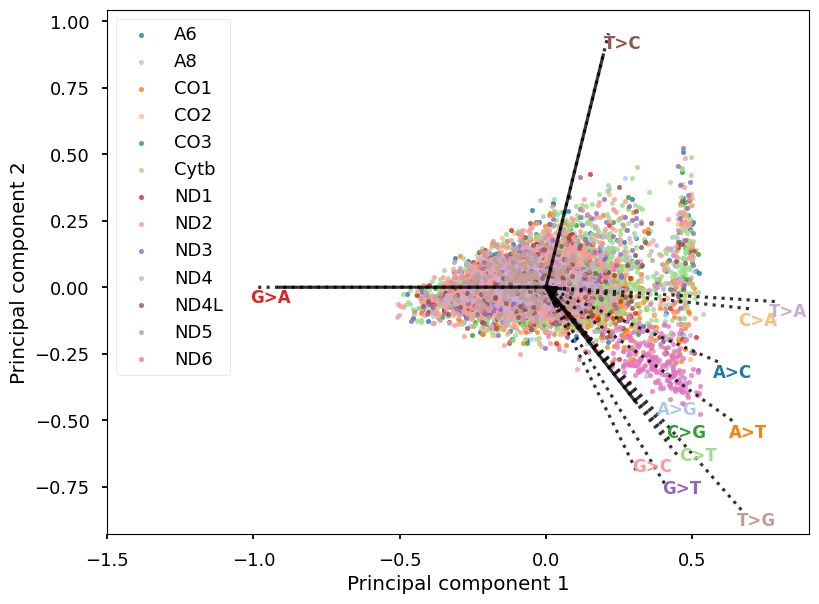

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from psynlig import pca_2d_scores, pca_2d_loadings
plt.style.use('seaborn-talk')

X = sp12.fillna(0.)
xvars = X.columns.values

labels = X.index.to_series().apply(lambda x: x.split('__')[0]).astype('category')
class_data = labels.cat.codes.values
class_names = {i:s for i,s in enumerate(labels.cat.categories)}

pca = PCA(2)
scores = pca.fit_transform(X)

loading_settings = {
    'adjust_text': True,
    'add_text': True,
    # 'jiggle_text': True,
}

figs, axes = pca_2d_scores(
    pca,
    scores,
    xvars=xvars,
    class_data=class_data,
    class_names=class_names,
    select_components={(1, 2)},
    loading_settings=loading_settings,
    s=10,
    alpha=.8,
    # cmap_class='Dark2',
)
figs[0].set_size_inches(8, 6)
axes[0].set_xlim(-1.5, 0.9)
# plt.legend(loc='upper left')
plt.show()

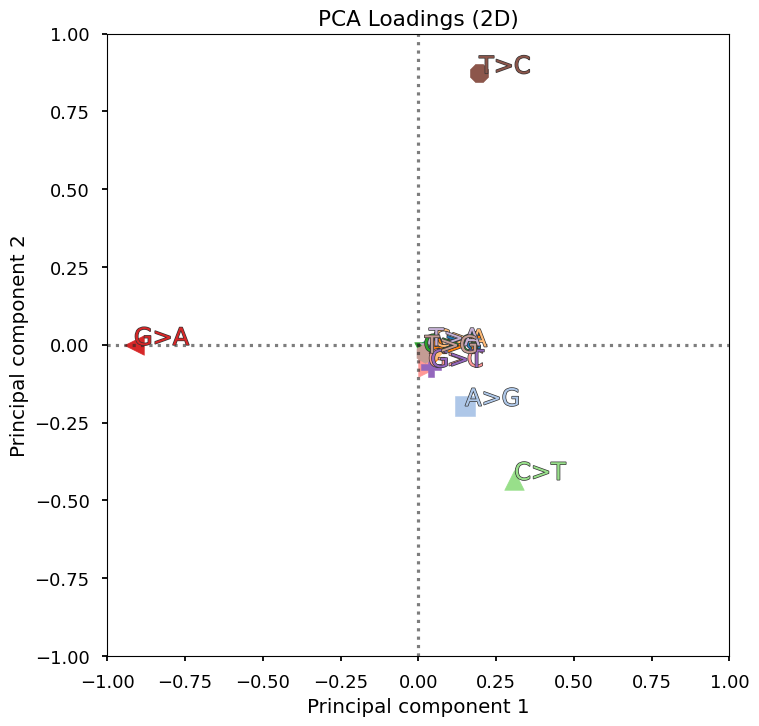

In [ ]:
# PCA Loadings (2D)

text_settings = {
    'fontsize': 'xx-large',
    'outline': {'foreground': '0.2'}
}
pca_2d_loadings(
    pca, xvars,
    select_components={(1, 2)},
    text_settings=text_settings
)
plt.title('PCA Loadings (2D)')
plt.show()

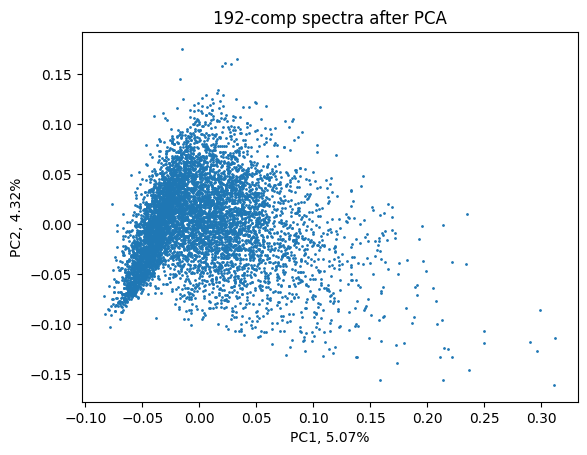

In [ ]:
X = sp192.fillna(0.)
n_components = 2  # Specify the number of dimensions you want to reduce to
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

# Plot the reduced dimensions
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=1)  # Modify according to your number of components
plt.xlabel(f'PC1, {pca.explained_variance_ratio_[0]*100:.2f}%')
plt.ylabel(f'PC2, {pca.explained_variance_ratio_[1]*100:.2f}%')
plt.title('192-comp spectra after PCA')
plt.show()

### All genes

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


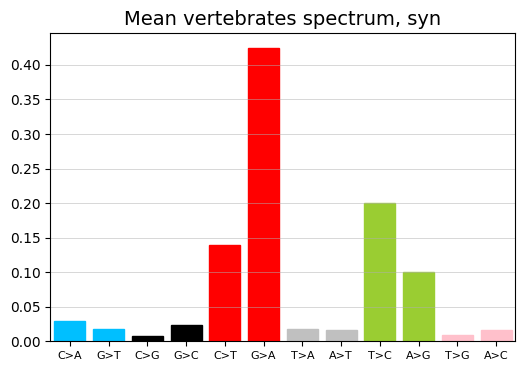

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


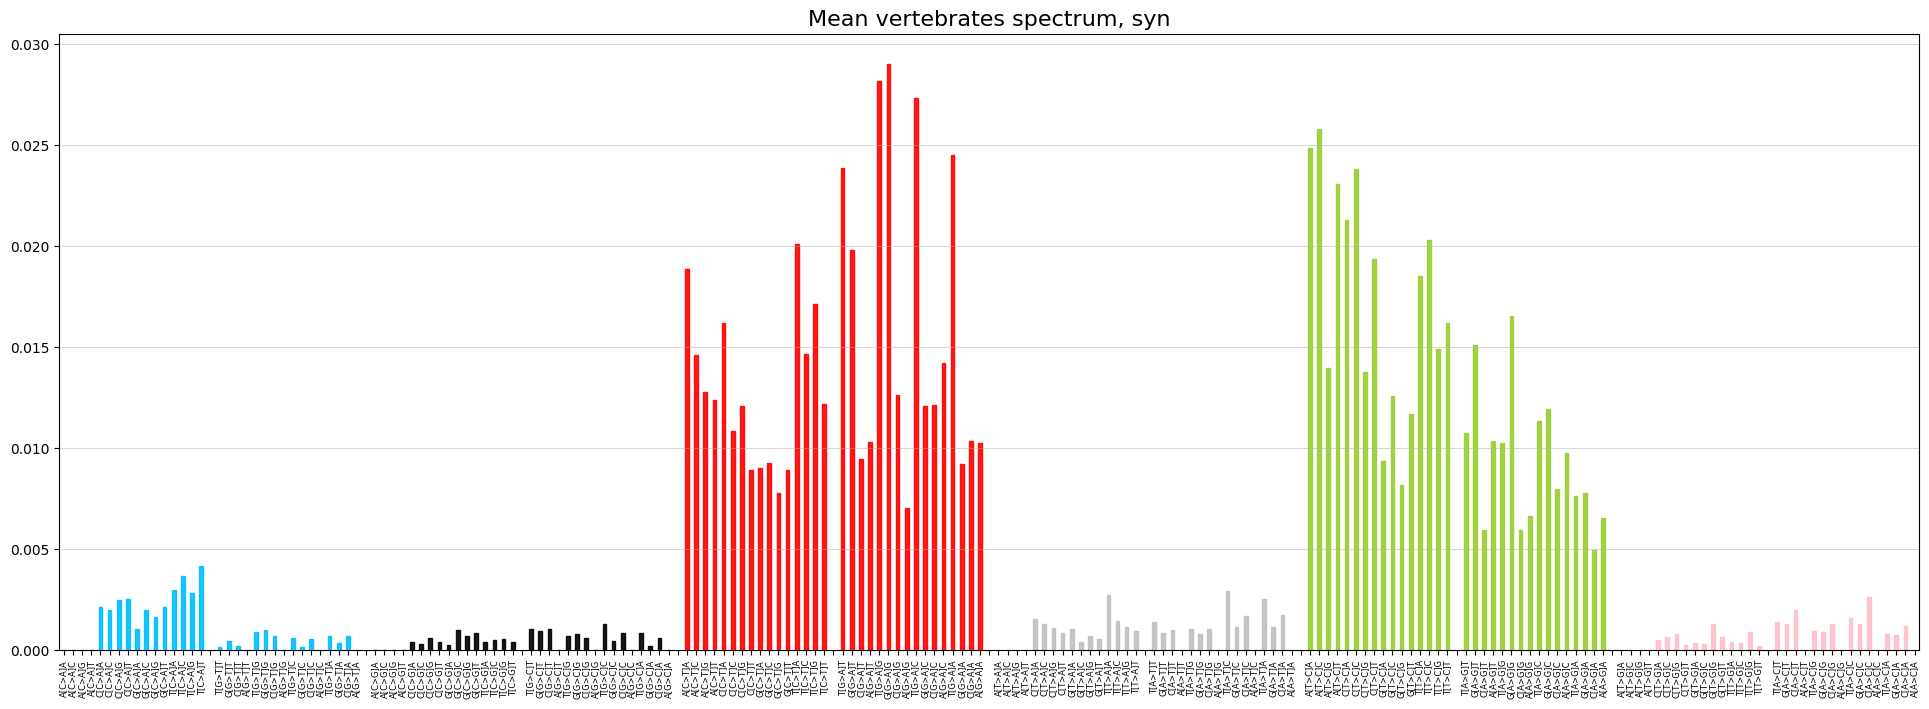

In [ ]:
# this is spectrum for all genes
plot_mutspec12(sp12.mean(axis=0).rename('MutSpec').reset_index(), title='Mean vertebrates spectrum, syn');
plot_mutspec192(sp192.fillna(0.).mean(axis=0).rename('MutSpec').reset_index(), title='Mean vertebrates spectrum, syn');

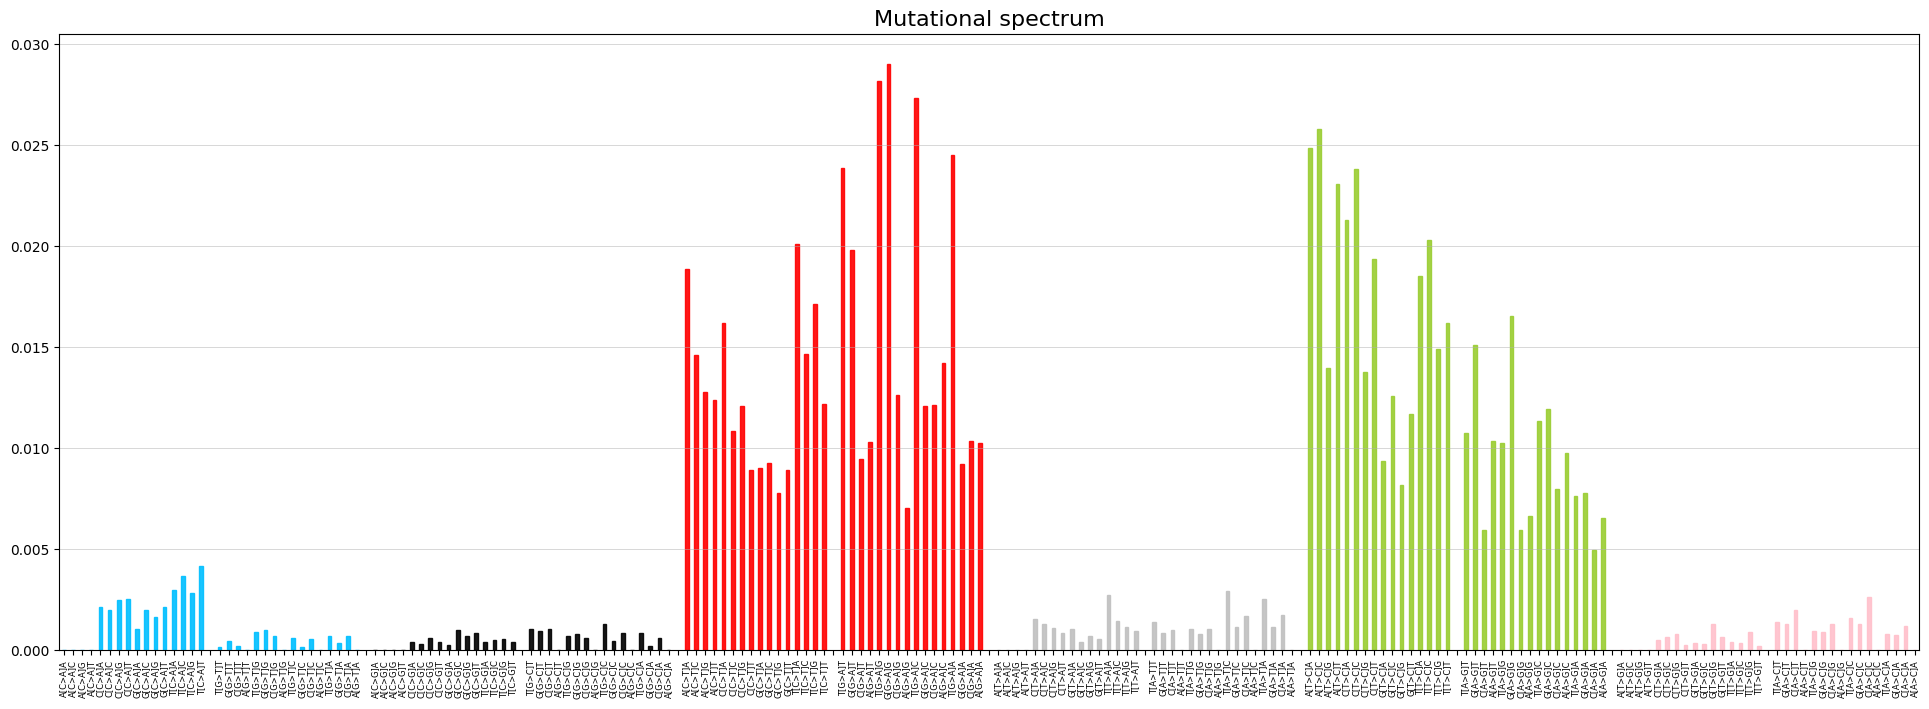

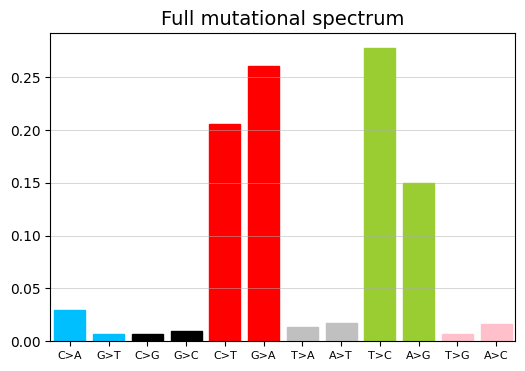

In [ ]:
# this is spectrum for all genes: 192->12
plot_mutspec192(a);
plot_mutspec12(collapse_sbs192(a.set_index('Mut').T).T.reset_index());

### Spectrum on genes

In [ ]:
genes = 'Cytb ND6 ND5 ND4 ND4L ND3 CO3 A6 A8 CO2 CO1 ND2 ND1'.split()
assert len(genes) == 13

In [ ]:
# # # collapse 192 -> 12
# for gene in genes:
#     a = sp192.loc[sp192.index.str.startswith(gene)]
#     nspecies = len(a)
#     a = a.mean(axis=0).reset_index()
#     a.columns = ['Mut', 'MutSpec']

#     plot_mutspec12(collapse_sbs192(a.set_index('Mut').T).T.reset_index(), 
#                    title=f"{gene}; nspecies={nspecies}", figsize=(4, 2.5));

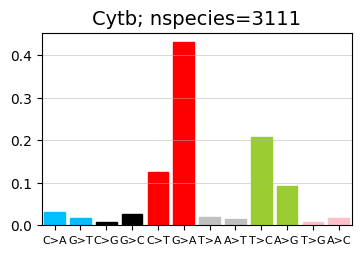

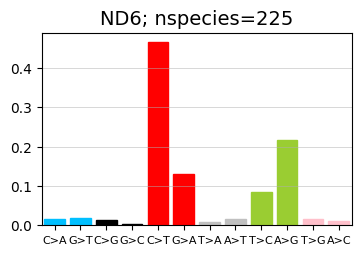

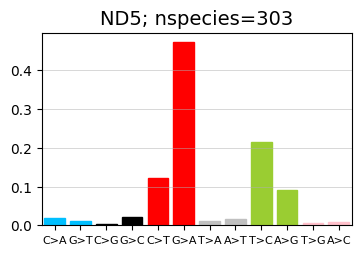

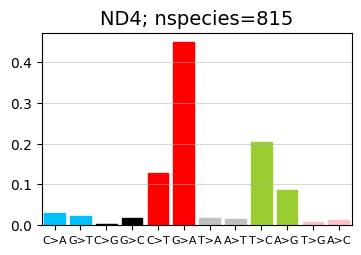

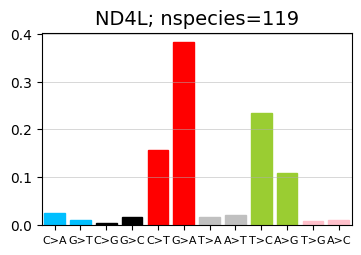

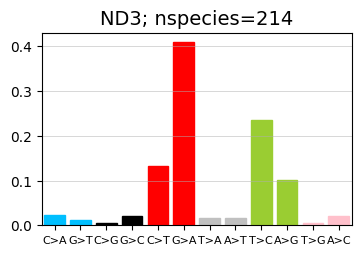

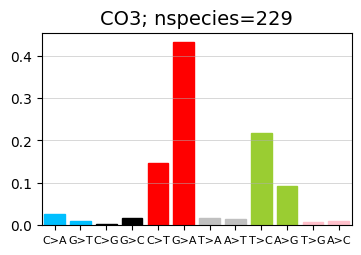

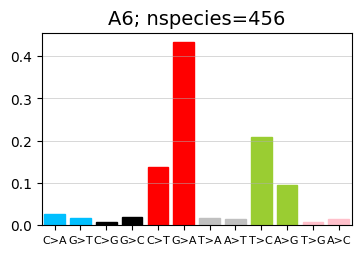

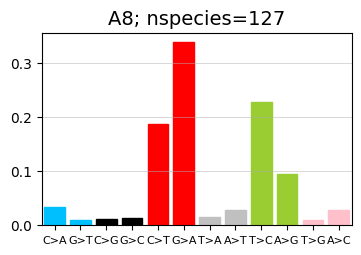

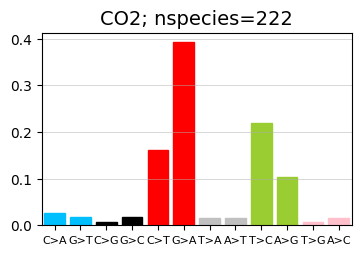

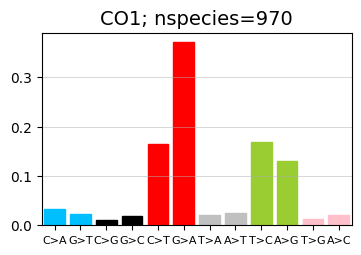

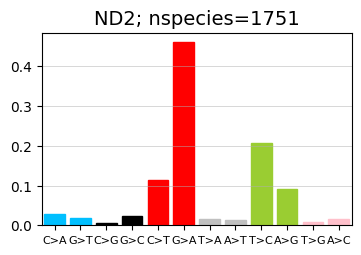

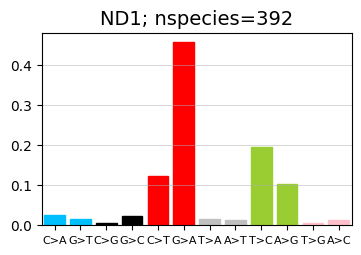

In [ ]:
for gene in genes:
    a = sp12.loc[sp12.index.str.startswith(gene)]
    nspecies = len(a)
    a = a.mean(axis=0).reset_index()
    a.columns = ['Mut', 'MutSpec']

    plot_mutspec12(a, title=f"{gene}; nspecies={nspecies}", figsize=(4, 2.5));

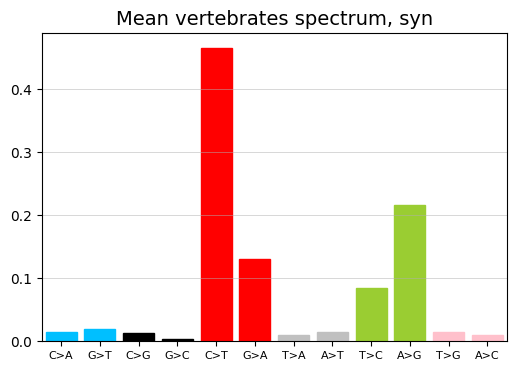

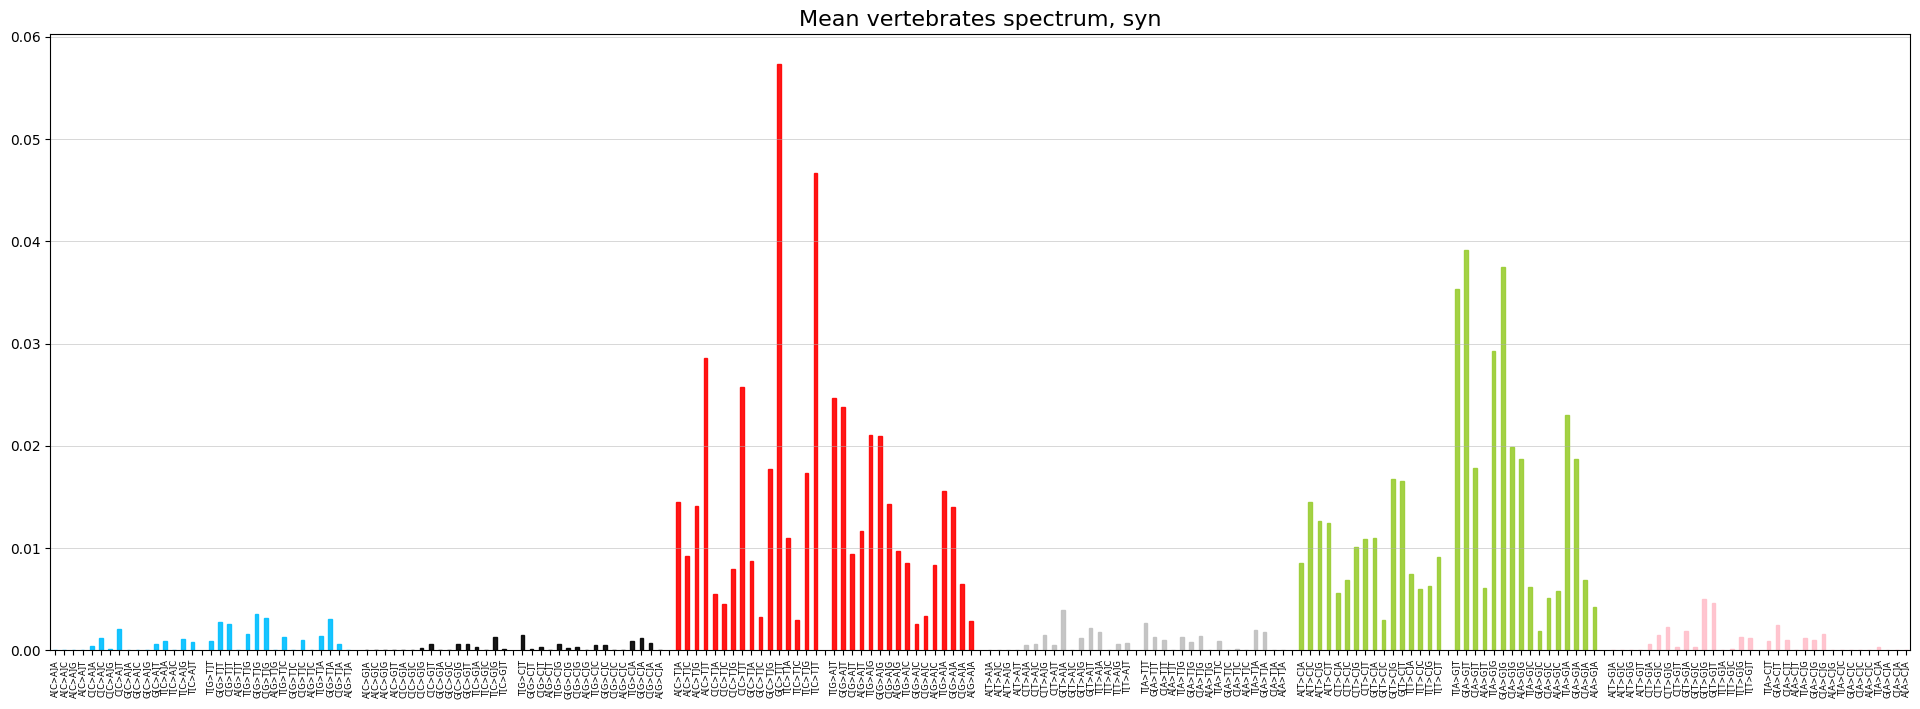

In [ ]:
# this is spectrum for ND6
plot_mutspec12(sp12[sp12.index.str.startswith('ND6')].mean(axis=0).rename('MutSpec').reset_index(), title='Mean vertebrates spectrum, syn');
plot_mutspec192(sp192[sp192.index.str.startswith('ND6')].fillna(0.).mean(axis=0).rename('MutSpec').reset_index(), title='Mean vertebrates spectrum, syn');

## Decomposition
ha-ha

ncomp = 1, train cossim = 0.55, test cossim = 0.54
ncomp = 2, train cossim = 0.57, test cossim = 0.57
ncomp = 3, train cossim = 0.60, test cossim = 0.60


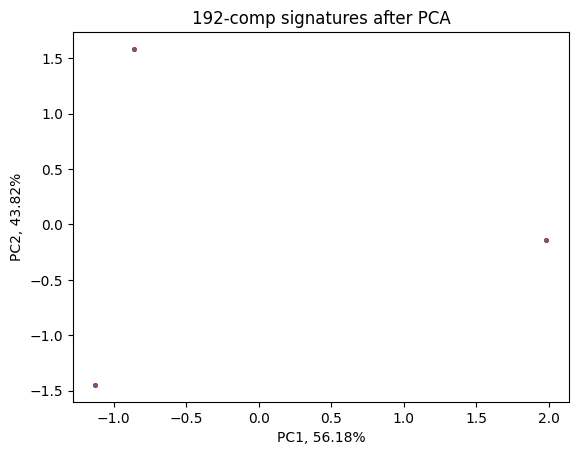


ncomp = 4, train cossim = 0.62, test cossim = 0.62


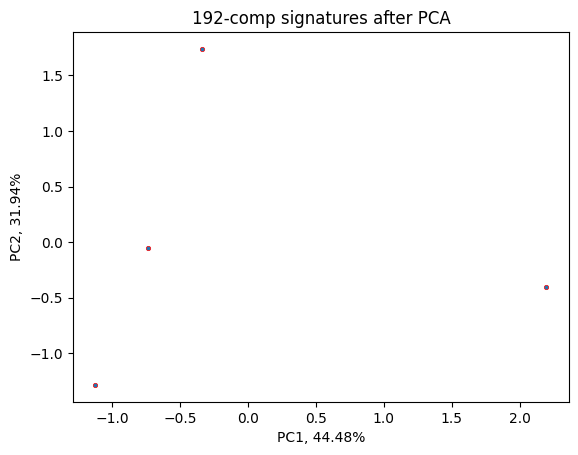


ncomp = 5, train cossim = 0.64, test cossim = 0.63


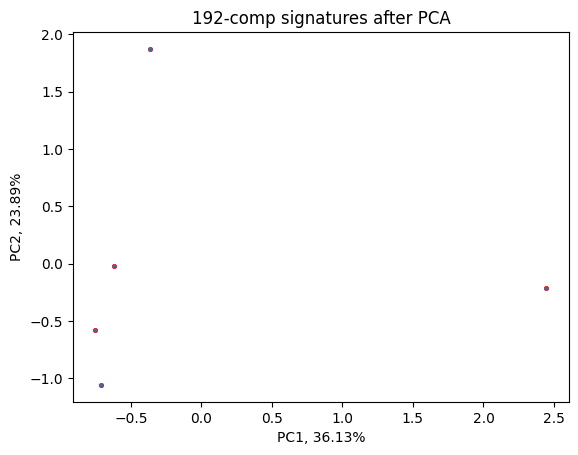


ncomp = 6, train cossim = 0.66, test cossim = 0.65


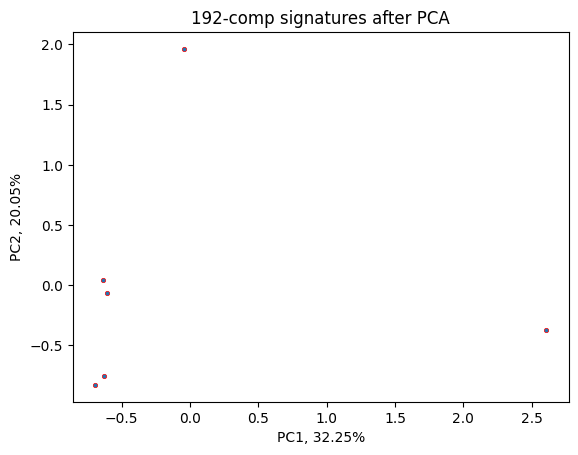


ncomp = 7, train cossim = 0.67, test cossim = 0.67


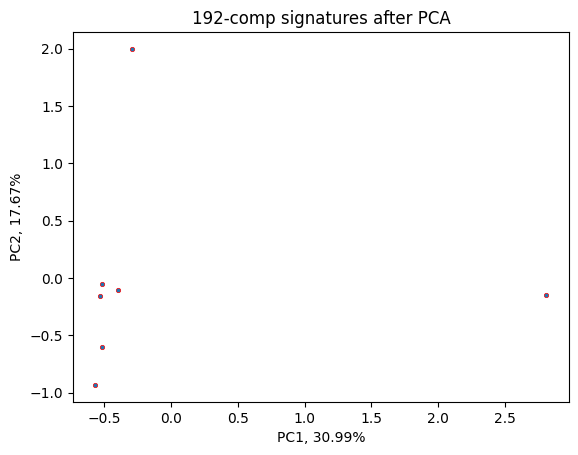


ncomp = 8, train cossim = 0.69, test cossim = 0.68


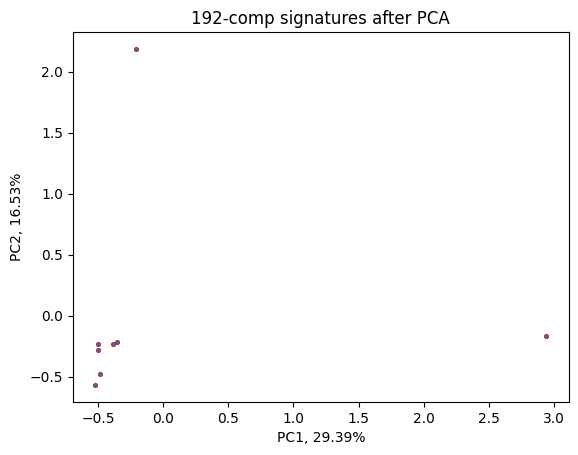


ncomp = 9, train cossim = 0.71, test cossim = 0.70


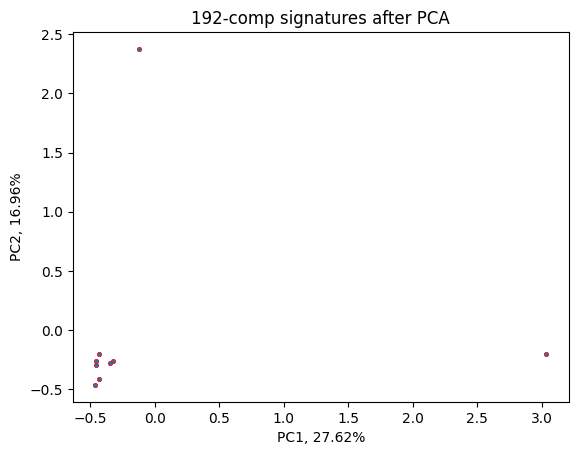


ncomp = 10, train cossim = 0.72, test cossim = 0.71


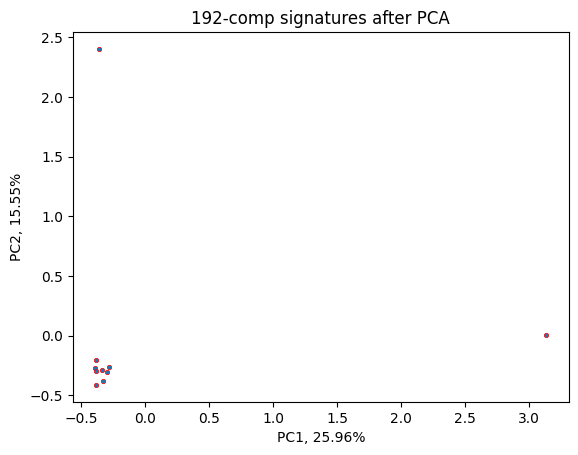

In [ ]:
import numpy as np
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split

# Example data matrix X (replace this with your actual data)
X = sp192.copy()

# Split the data into training and test sets
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Range of component numbers to try
component_range = range(1, 11)

# Test NMF with different numbers of components
for n_components in component_range:
    # Create and fit the NMF model to the training data
    model = NMF(n_components=n_components, random_state=42, max_iter=500)
    W = model.fit_transform(X_train)
    H = model.components_
    
    # Reconstruct the test data
    X_reconstructed = np.dot(W, H)
    rec_df_train = pd.DataFrame(X_reconstructed, index=X_train.index, columns=X_train.columns)
    
    X_reconstructed_test = model.inverse_transform(model.transform(X_test))
    rec_df_test = pd.DataFrame(X_reconstructed_test, index=X_test.index, columns=X_test.columns)

    # Calculate the reconstruction error on the test data
    cossims_train = get_cossim(X_train, rec_df_train)
    cossims_test = get_cossim(X_test, rec_df_test)

    print(f"ncomp = {n_components}, train cossim = {cossims_train.mean():.2f}, test cossim = {cossims_test.mean():.2f}")

    if n_components > 2:
        signatures = pd.DataFrame(H, columns=X_train.columns)
        pca = PCA(2)
        X_pca = pca.fit_transform(signatures)

        # Plot the reduced dimensions
        plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, edgecolors='red', linewidths=0.5)
        plt.xlabel(f'PC1, {pca.explained_variance_ratio_[0]*100:.2f}%')
        plt.ylabel(f'PC2, {pca.explained_variance_ratio_[1]*100:.2f}%')
        plt.title('192-comp signatures after PCA')
        plt.show()
        print()


In [ ]:
Ts_lst = []
for x in possible_sbs192:
    for _ts in ['C>T','T>C','A>G','G>A']:
        if _ts in x:
            Ts_lst.append(x)

In [ ]:
# Ts only
import numpy as np
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Example data matrix X (replace this with your actual data)
X = sp192[Ts_lst].copy()

# Split the data into training and test sets
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Range of component numbers to try
component_range = range(1, 21)

# Test NMF with different numbers of components
for n_components in component_range:
    # Create and fit the NMF model to the training data
    model = NMF(n_components=n_components, random_state=42, max_iter=500)
    W = model.fit_transform(X_train)n
    H = model.components_
    
    # Reconstruct the test data
    X_reconstructed = np.dot(W, H)
    rec_df_train = pd.DataFrame(X_reconstructed, index=X_train.index, columns=X_train.columns)
    
    X_reconstructed_test = model.inverse_transform(model.transform(X_test))
    rec_df_test = pd.DataFrame(X_reconstructed_test, index=X_test.index, columns=X_test.columns)

    # Calculate the reconstruction error on the test data
    cossims_train = get_cossim(X_train, rec_df_train)
    cossims_test = get_cossim(X_test, rec_df_test)

    print(f"{n_components}, train cossim = {cossims_train.mean():.2f}, test cossim = {cossims_test.mean():.2f}")

    # if n_components > 2:
    #     signatures = pd.DataFrame(H, columns=X_train.columns)
    #     pca = PCA(2)
    #     X_pca = pca.fit_transform(signatures)

    #     # Plot the reduced dimensions
    #     plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, edgecolors='red', linewidths=0.5)
    #     plt.xlabel(f'PC1, {pca.explained_variance_ratio_[0]*100:.2f}%')
    #     plt.ylabel(f'PC2, {pca.explained_variance_ratio_[1]*100:.2f}%')
    #     plt.title('192-comp signatures after PCA')
    #     plt.show()
    #     print()


1, train cossim = 0.56, test cossim = 0.56
2, train cossim = 0.59, test cossim = 0.59
3, train cossim = 0.62, test cossim = 0.62
4, train cossim = 0.64, test cossim = 0.64
5, train cossim = 0.66, test cossim = 0.66
6, train cossim = 0.68, test cossim = 0.67
7, train cossim = 0.70, test cossim = 0.69
8, train cossim = 0.72, test cossim = 0.71
9, train cossim = 0.73, test cossim = 0.72
10, train cossim = 0.74, test cossim = 0.73
11, train cossim = 0.76, test cossim = 0.75
12, train cossim = 0.77, test cossim = 0.76
13, train cossim = 0.78, test cossim = 0.77
14, train cossim = 0.79, test cossim = 0.78
15, train cossim = 0.80, test cossim = 0.79
16, train cossim = 0.81, test cossim = 0.80
17, train cossim = 0.82, test cossim = 0.81
18, train cossim = 0.83, test cossim = 0.82
19, train cossim = 0.84, test cossim = 0.83
20, train cossim = 0.84, test cossim = 0.84


### Let's visualise the signatures

ncomp = 1, train cossim = 0.55, test cossim = 0.54


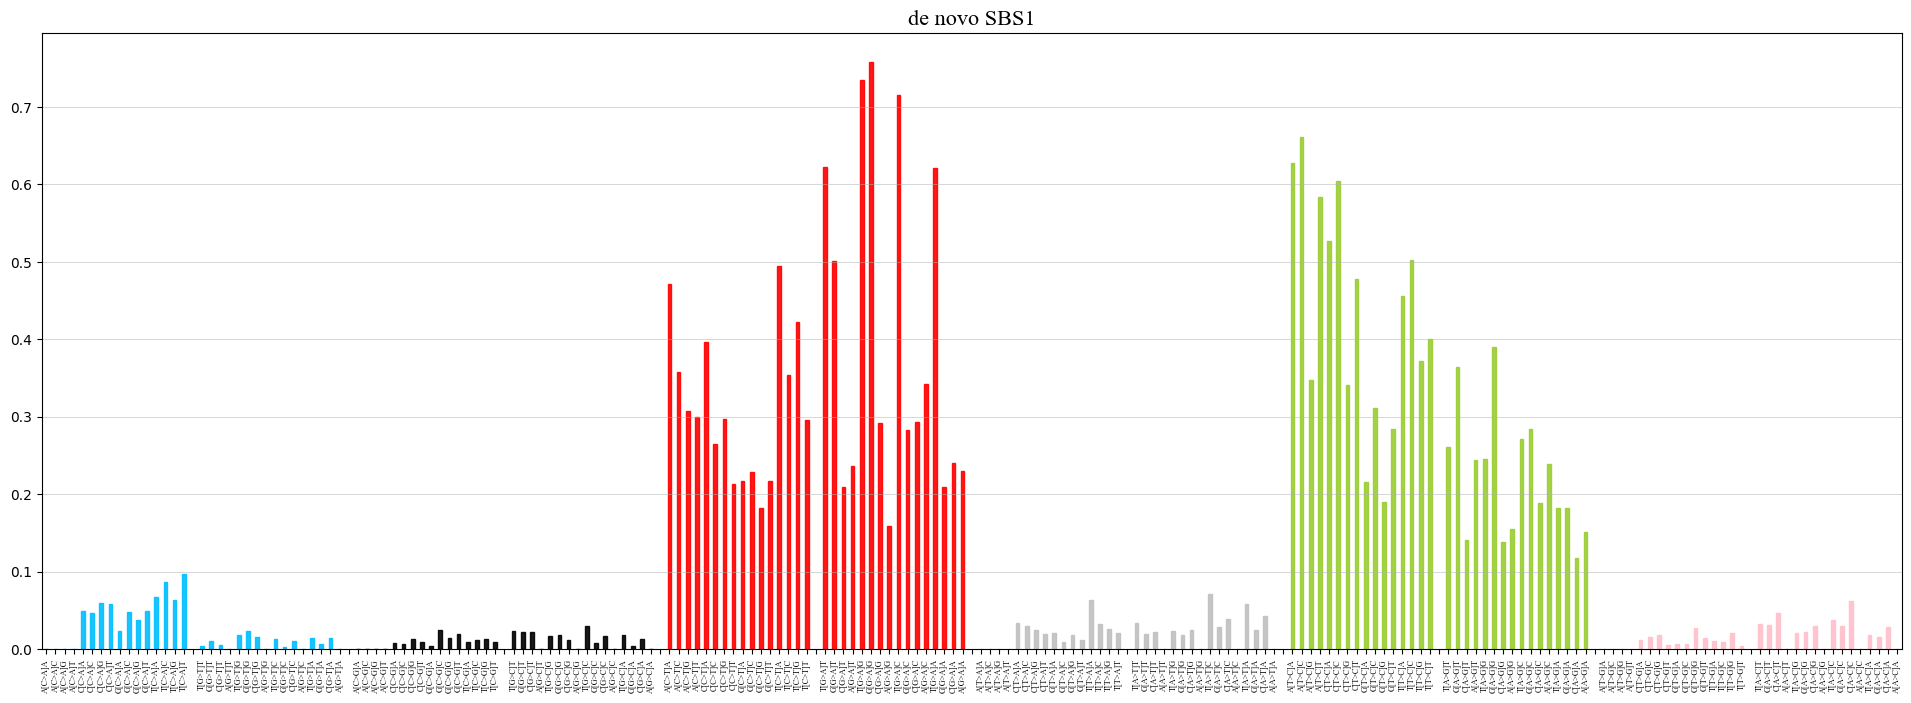

ncomp = 2, train cossim = 0.57, test cossim = 0.57


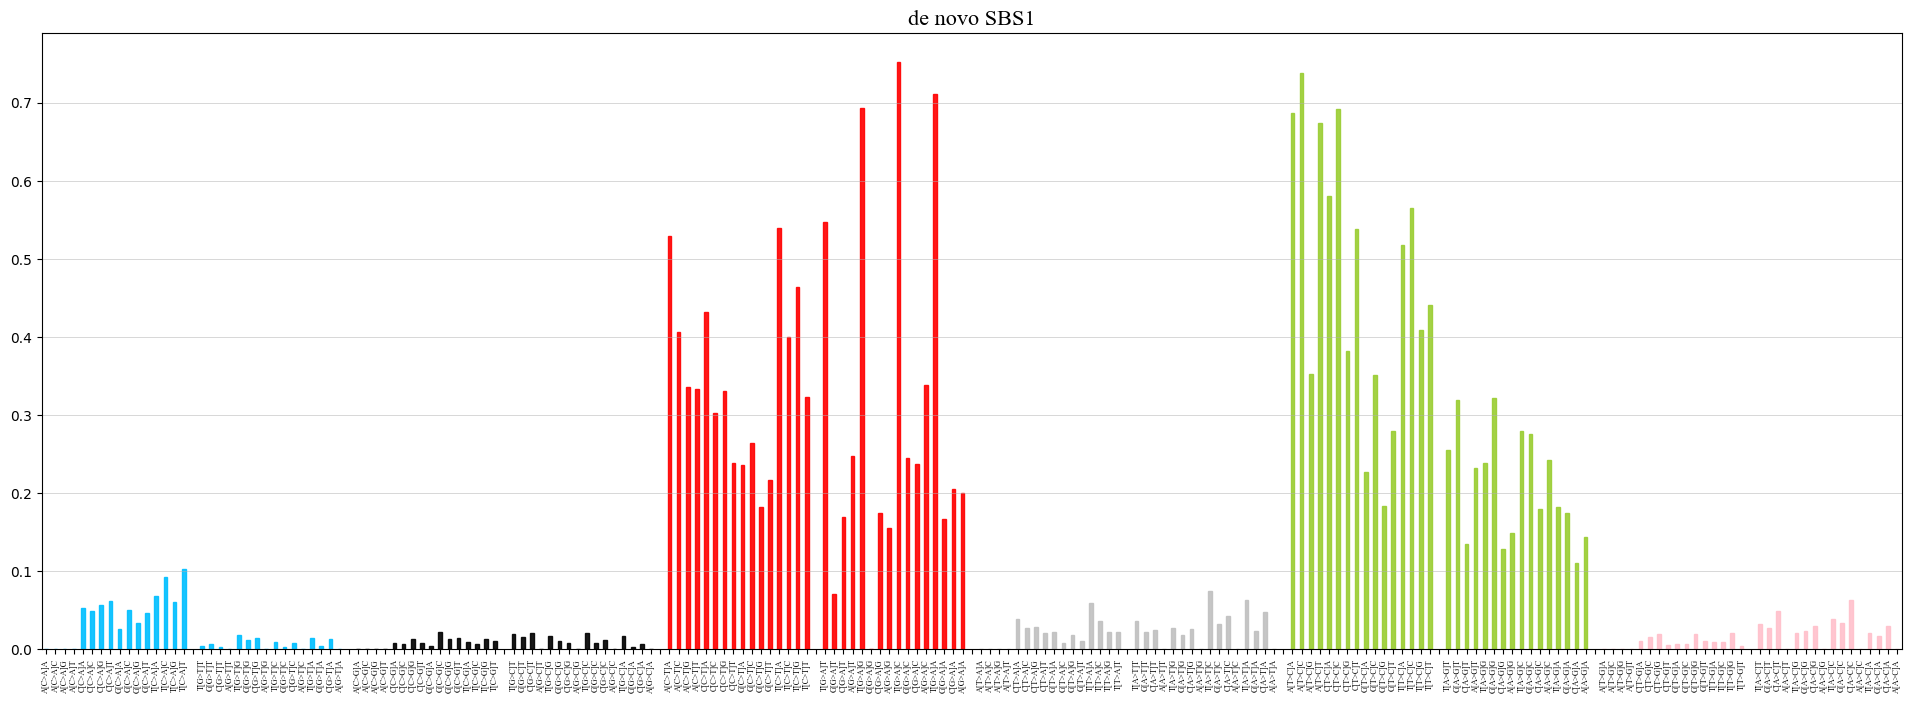

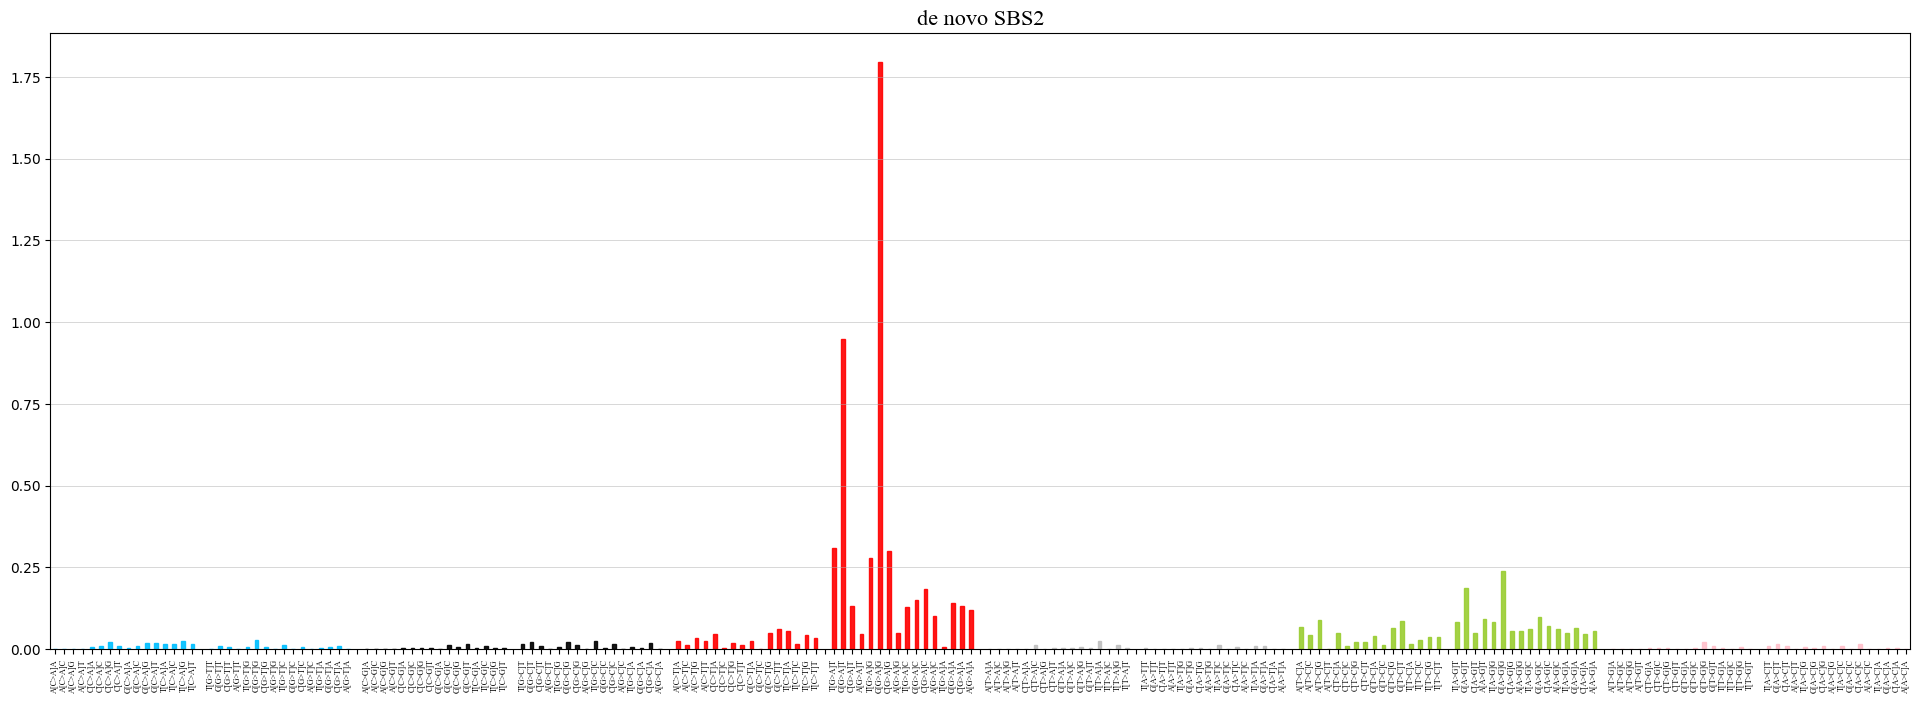

ncomp = 3, train cossim = 0.60, test cossim = 0.60


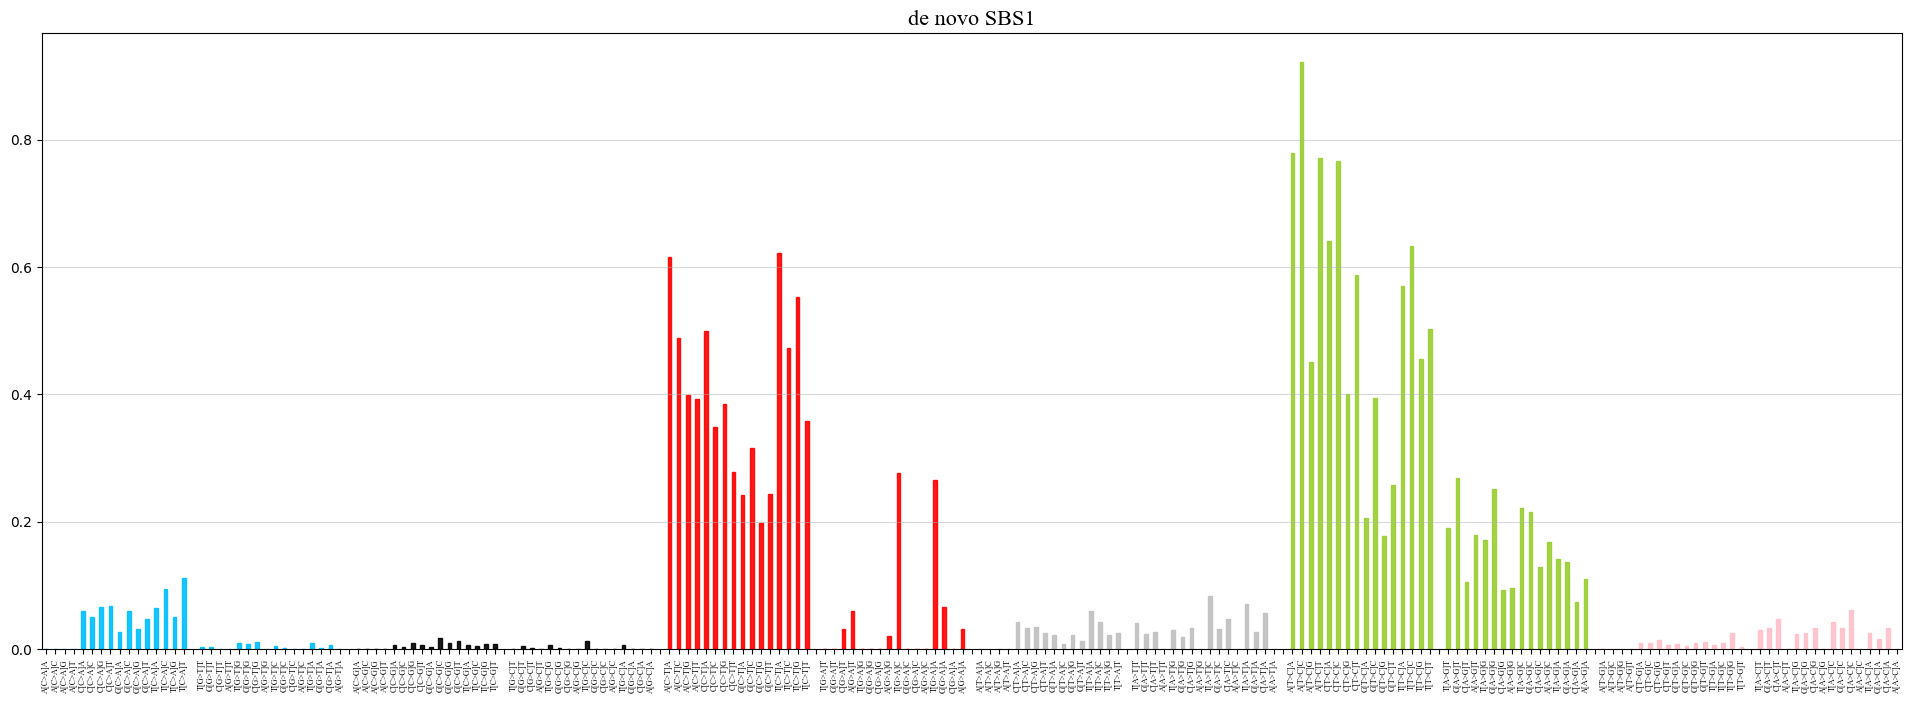

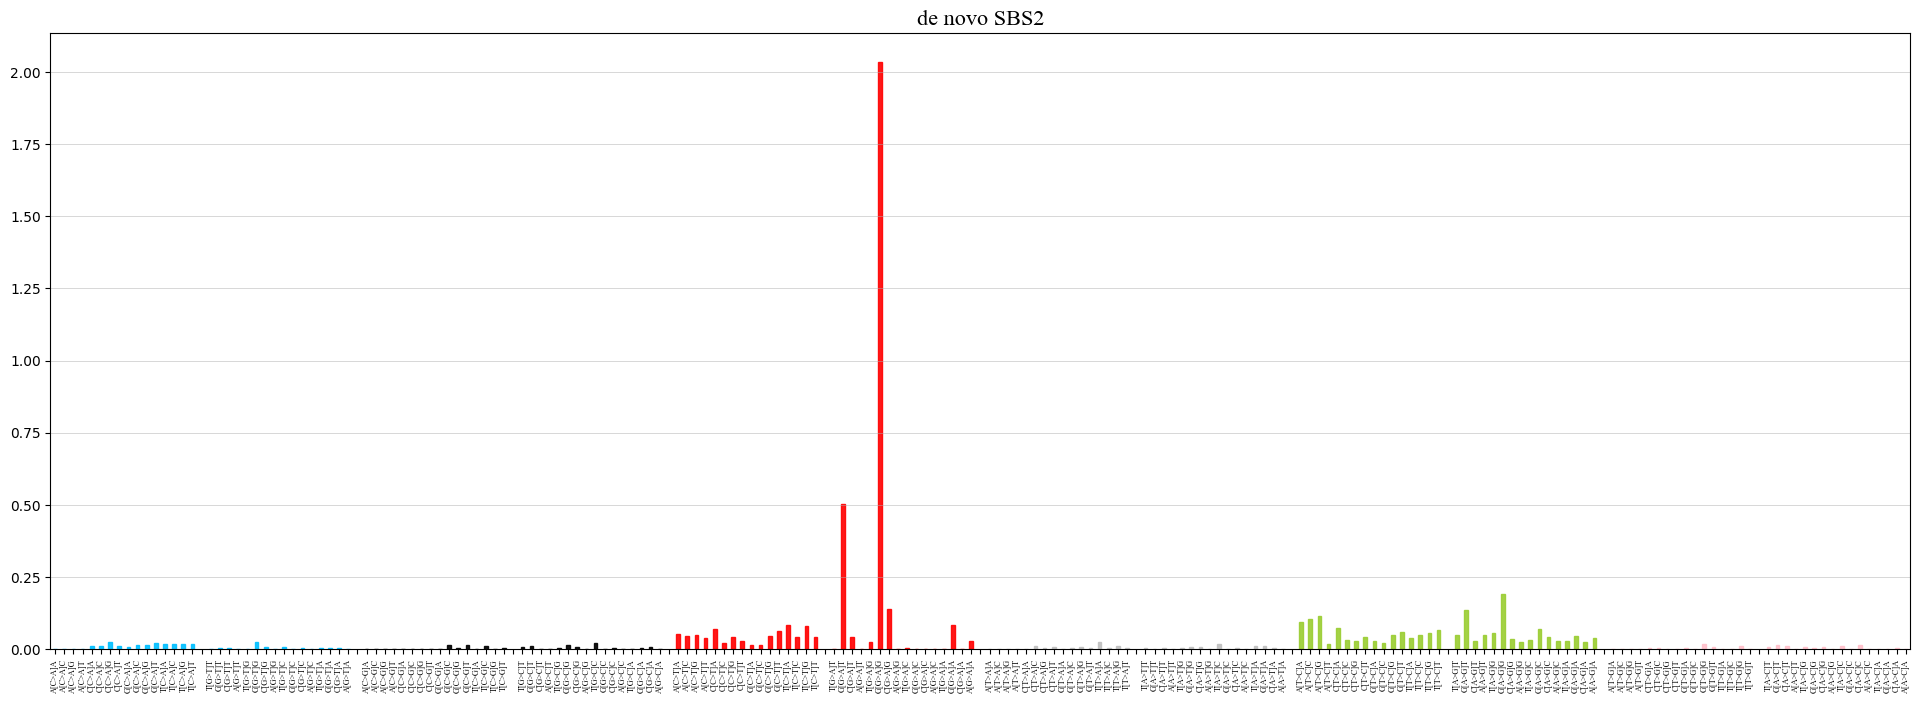

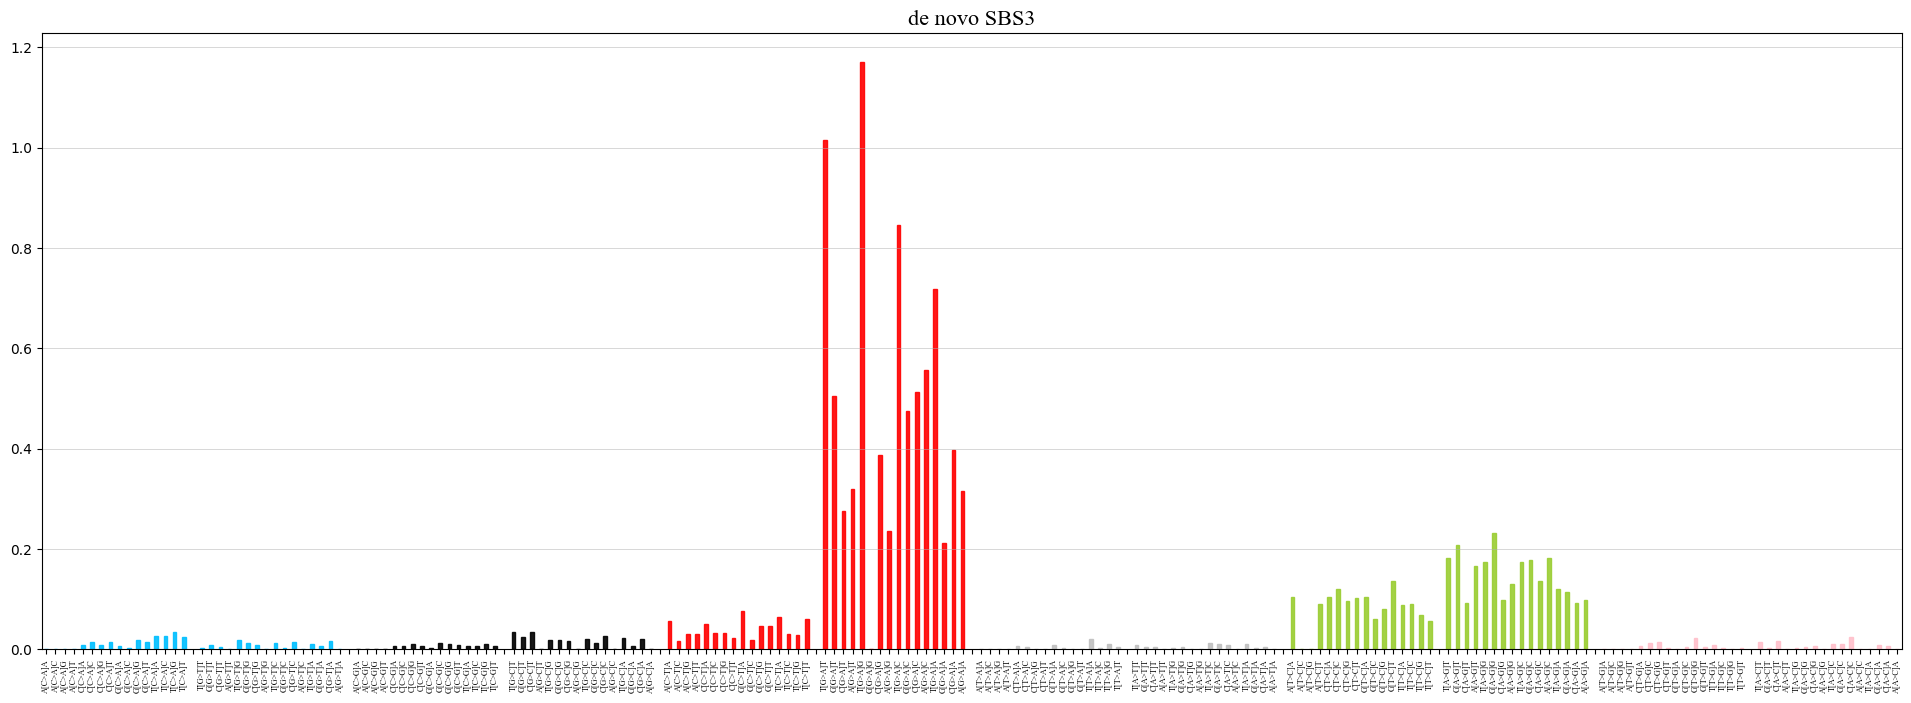

ncomp = 4, train cossim = 0.62, test cossim = 0.62


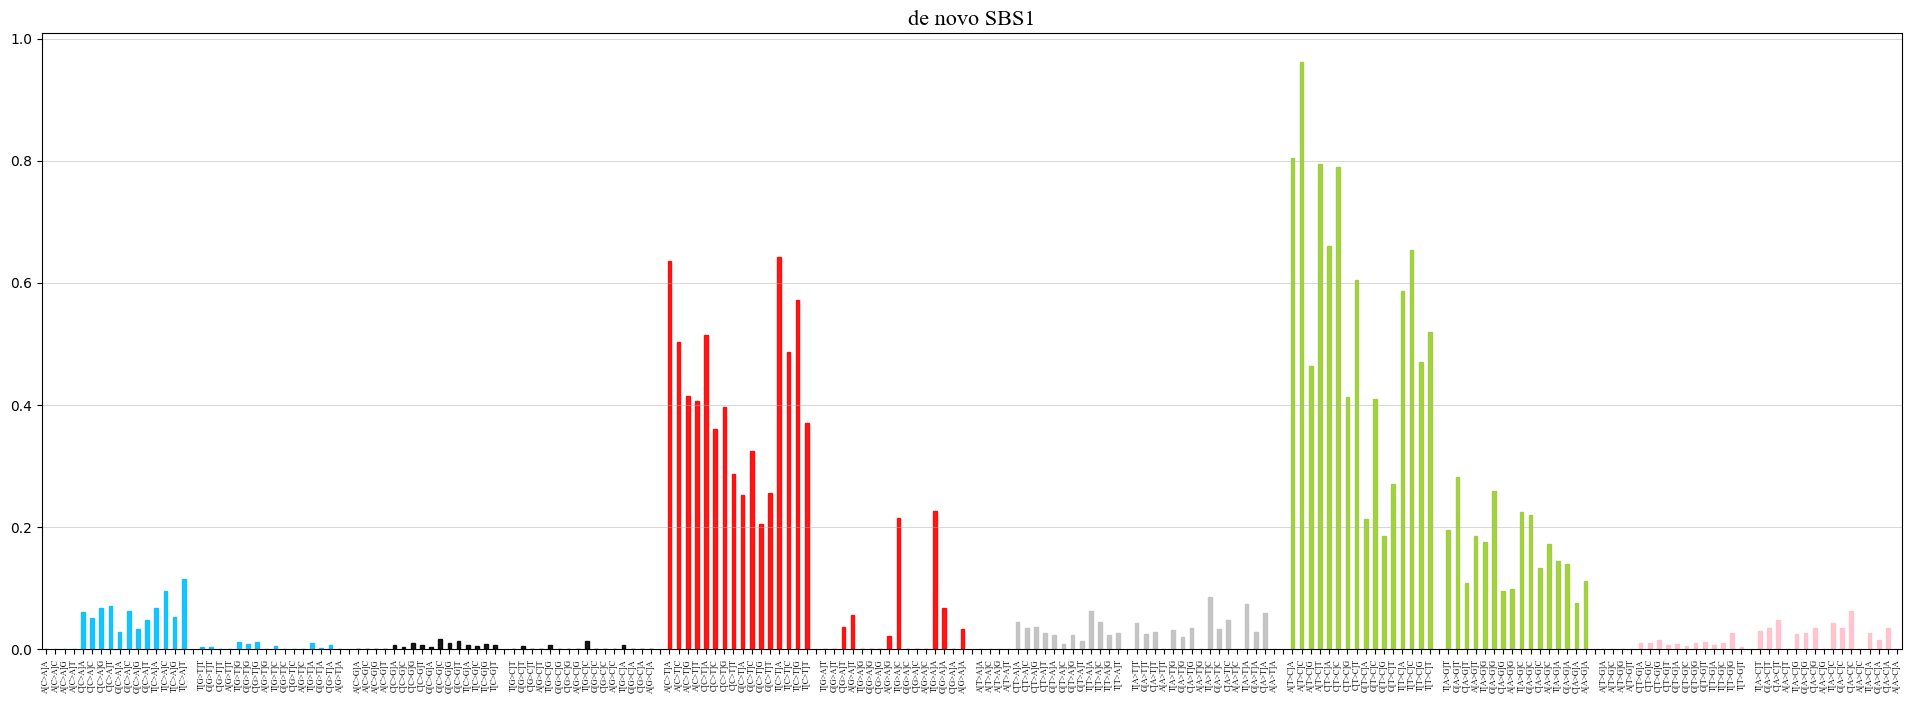

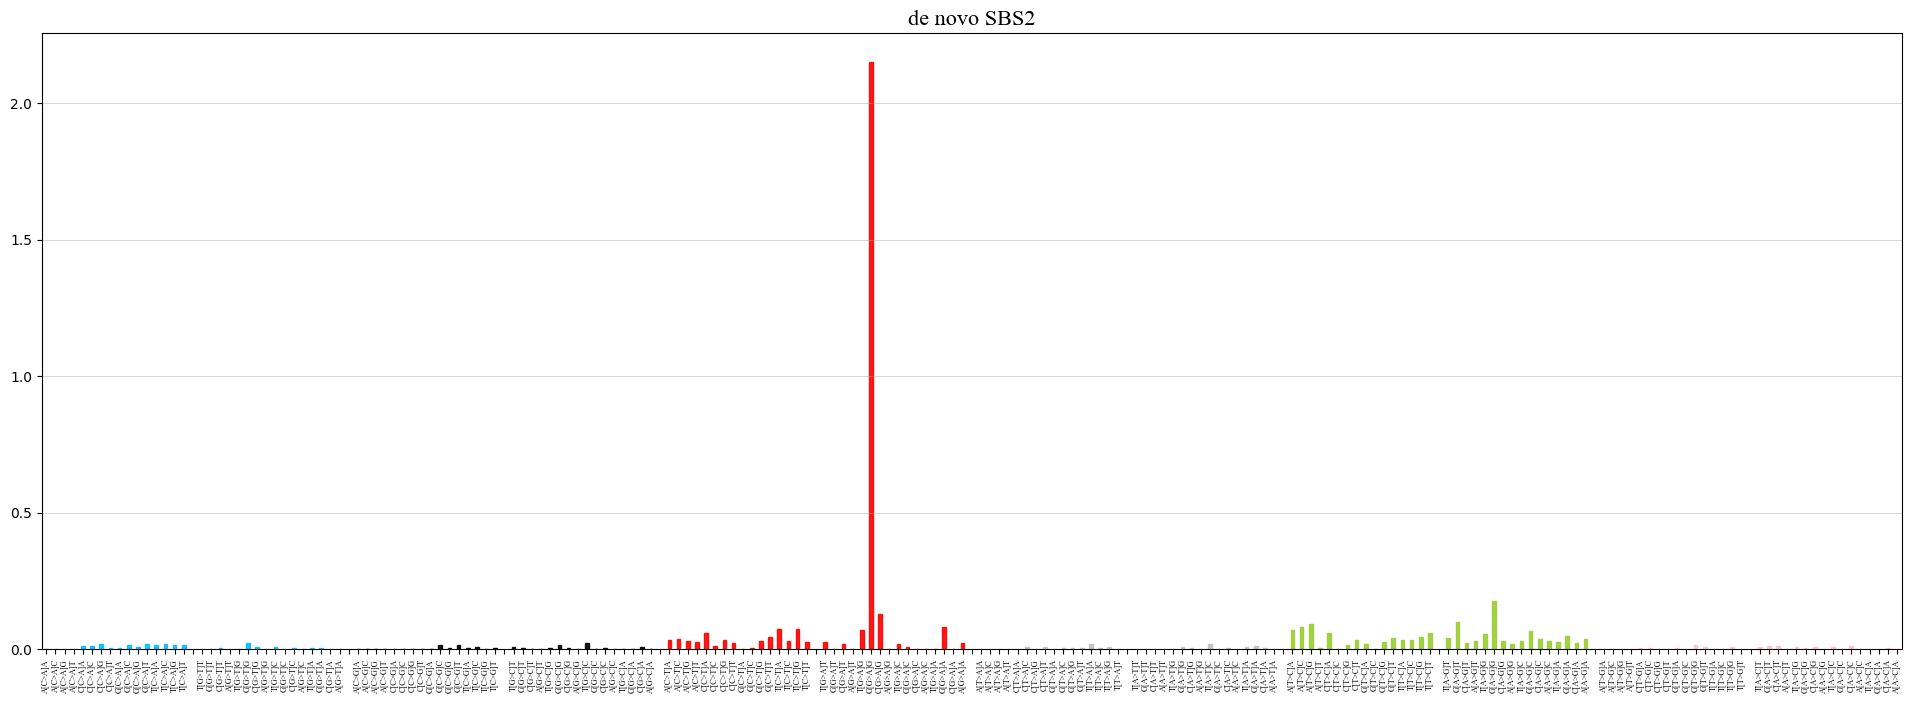

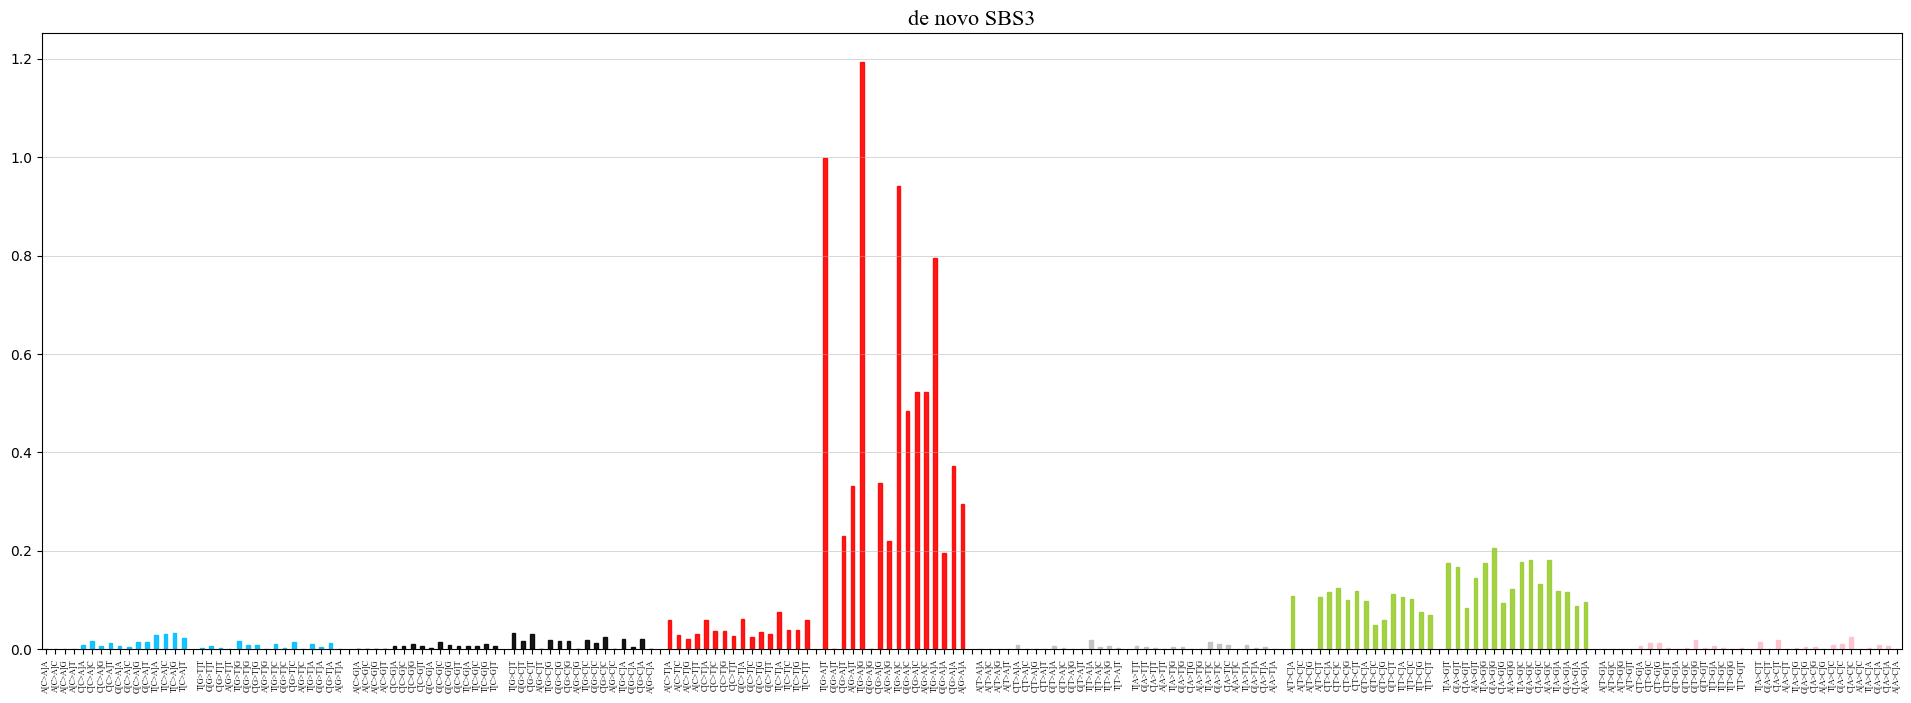

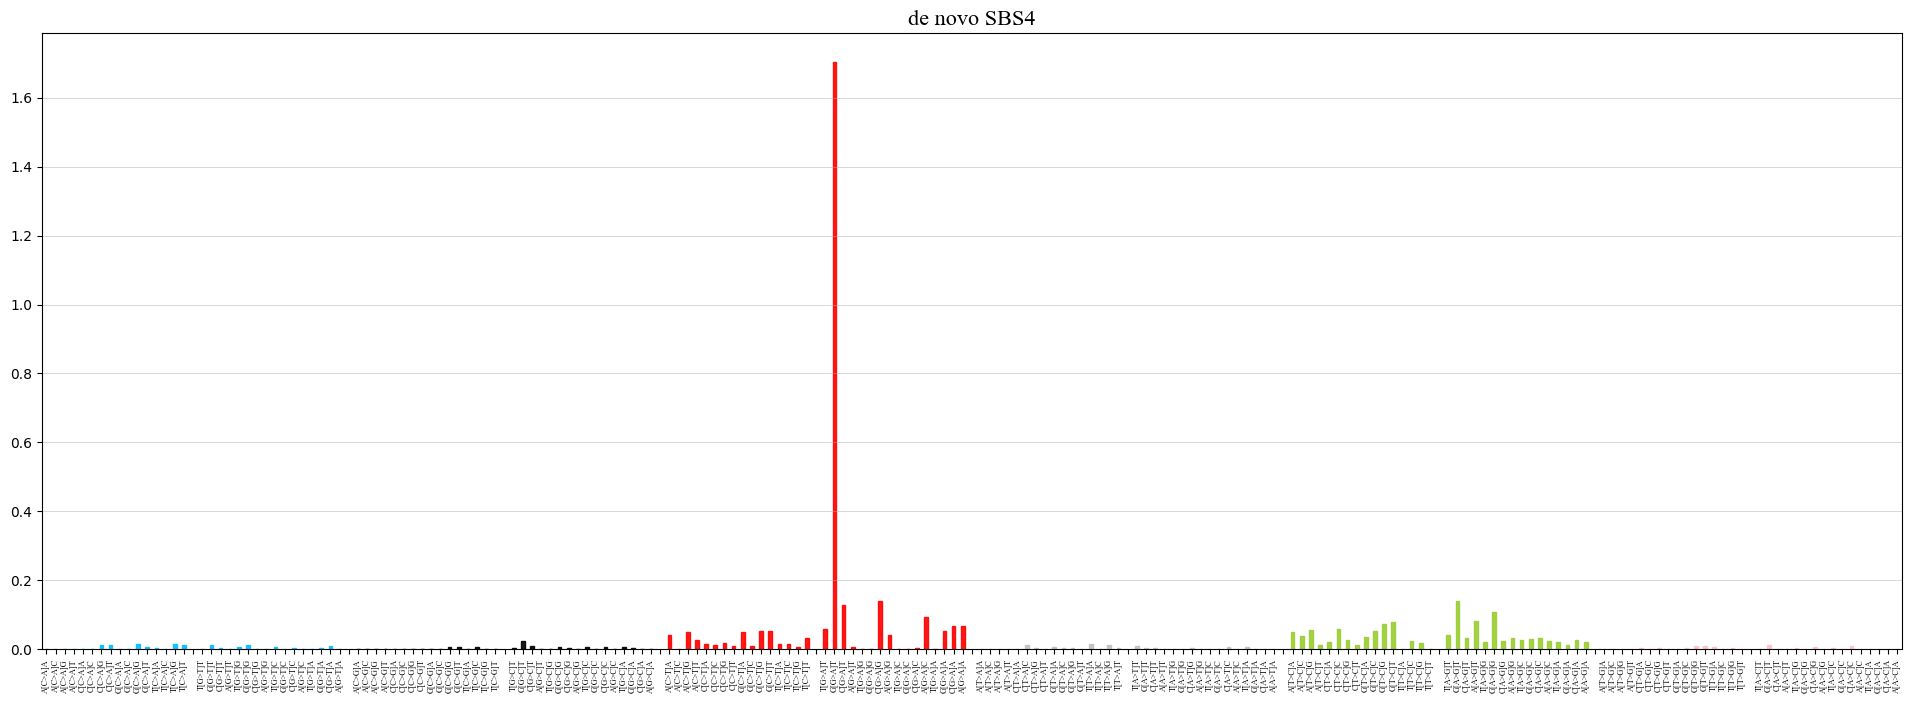

ncomp = 5, train cossim = 0.64, test cossim = 0.63


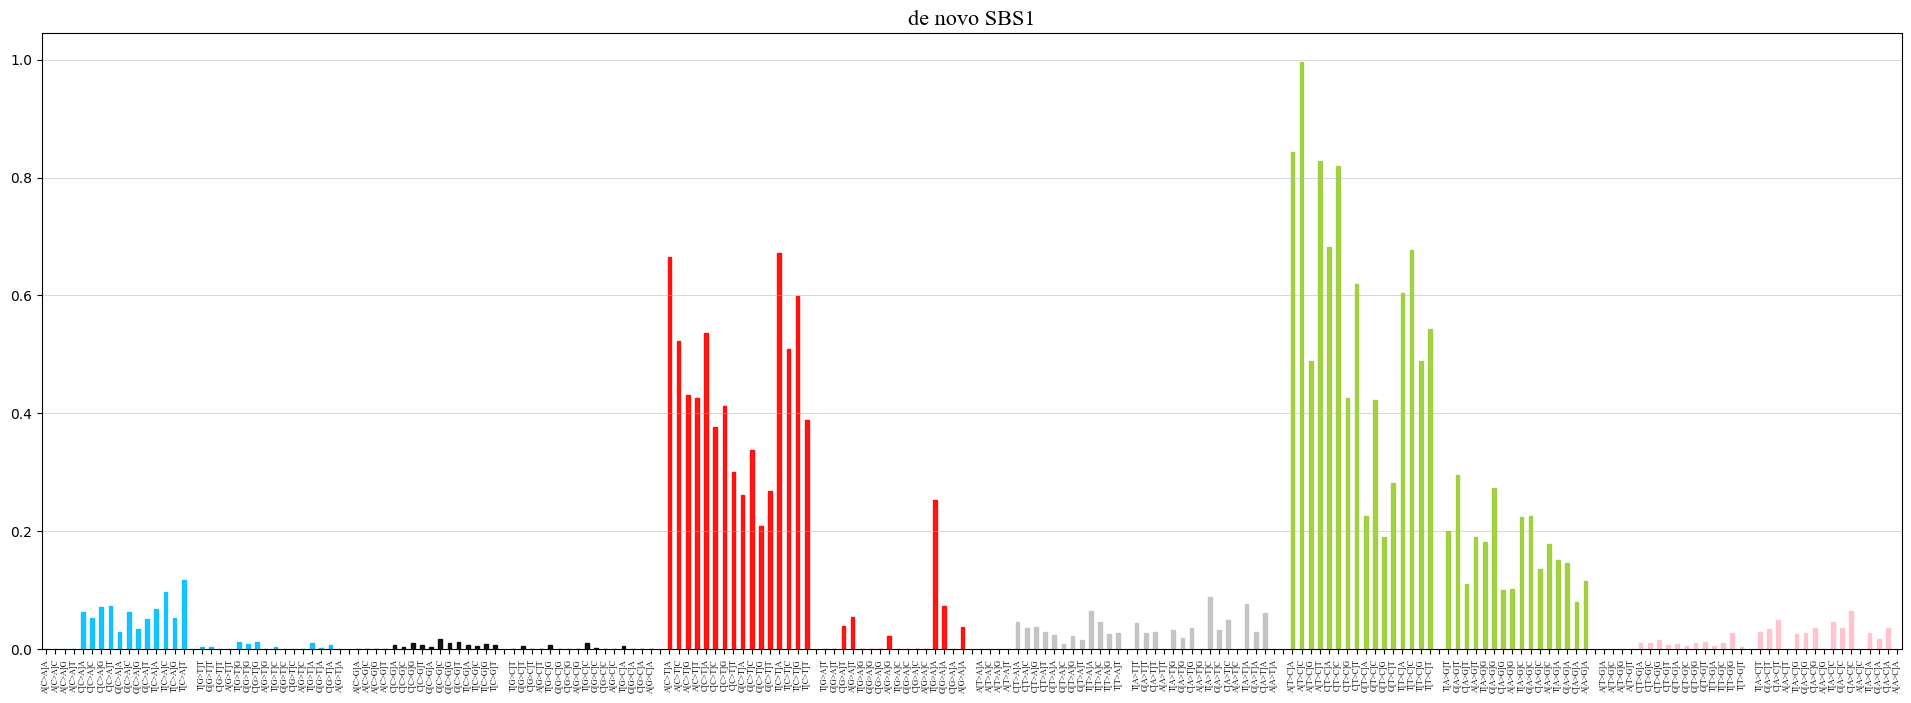

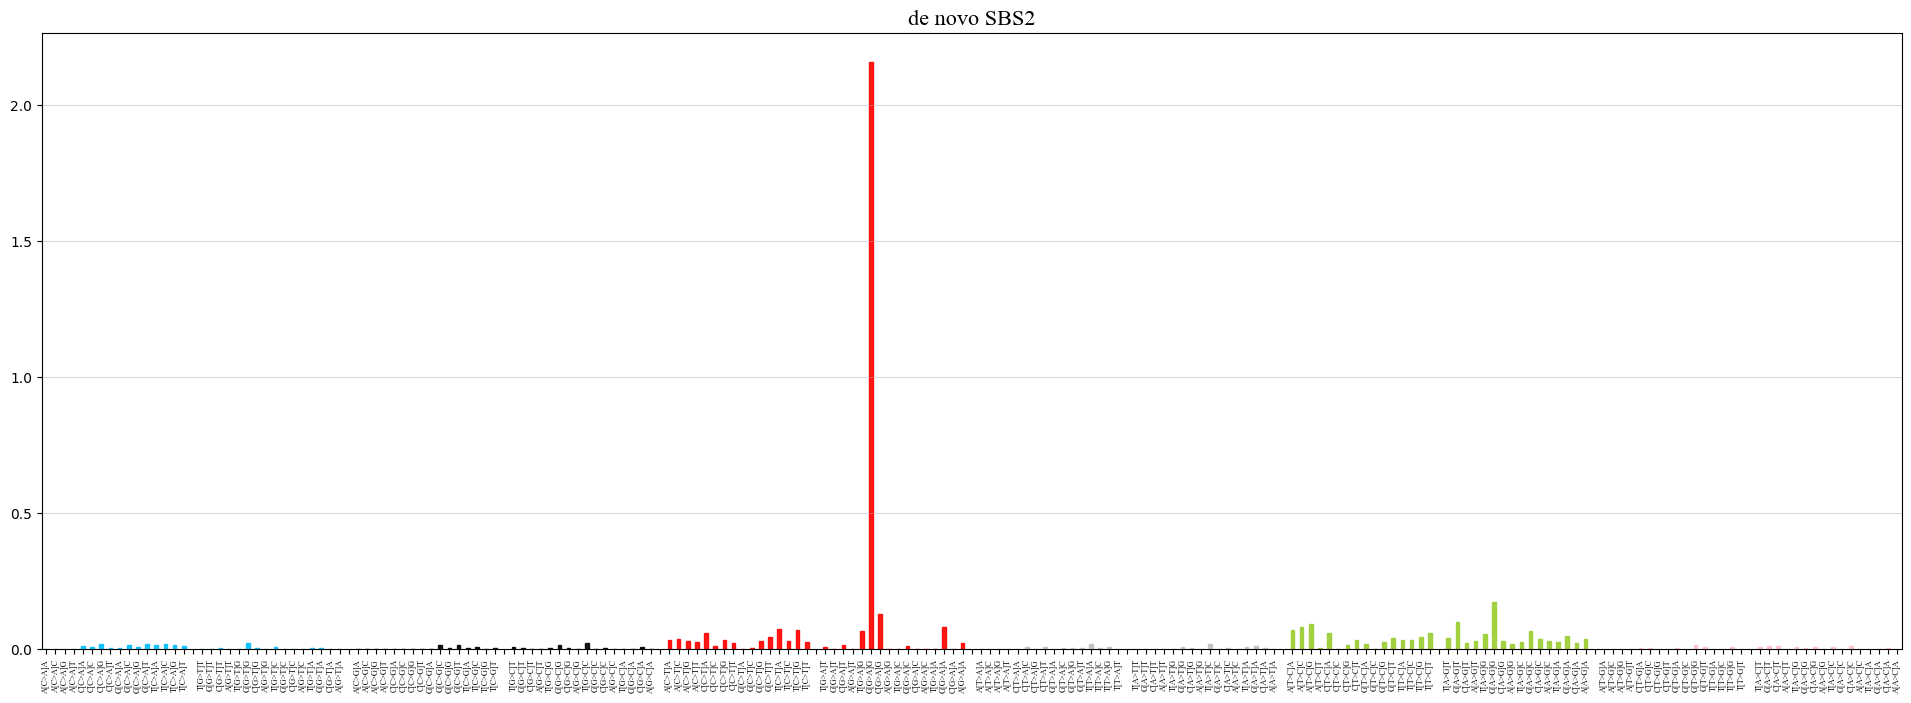

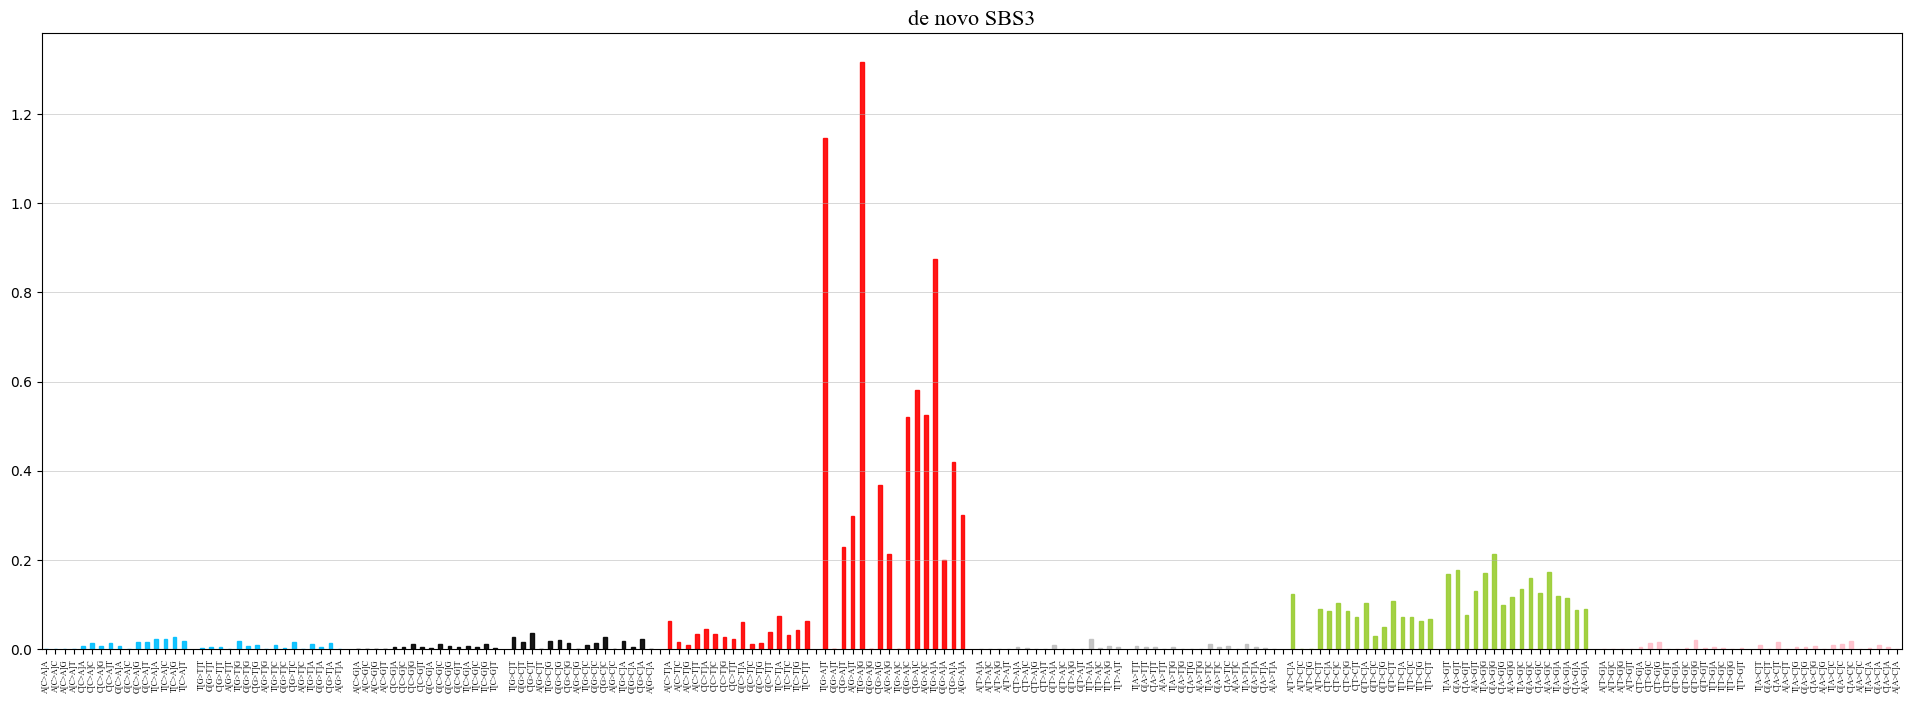

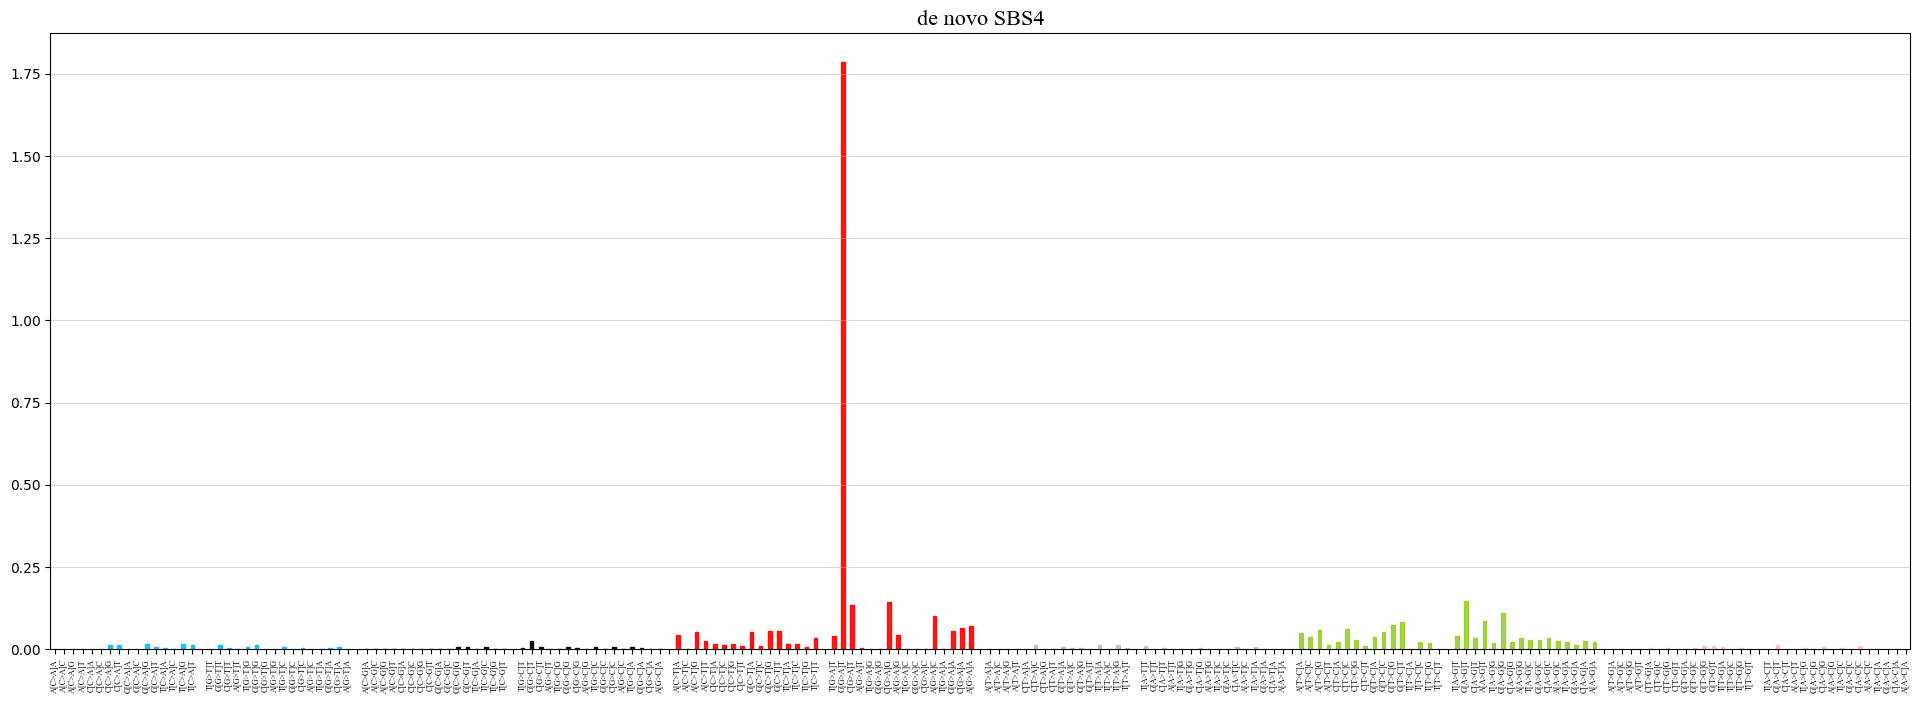

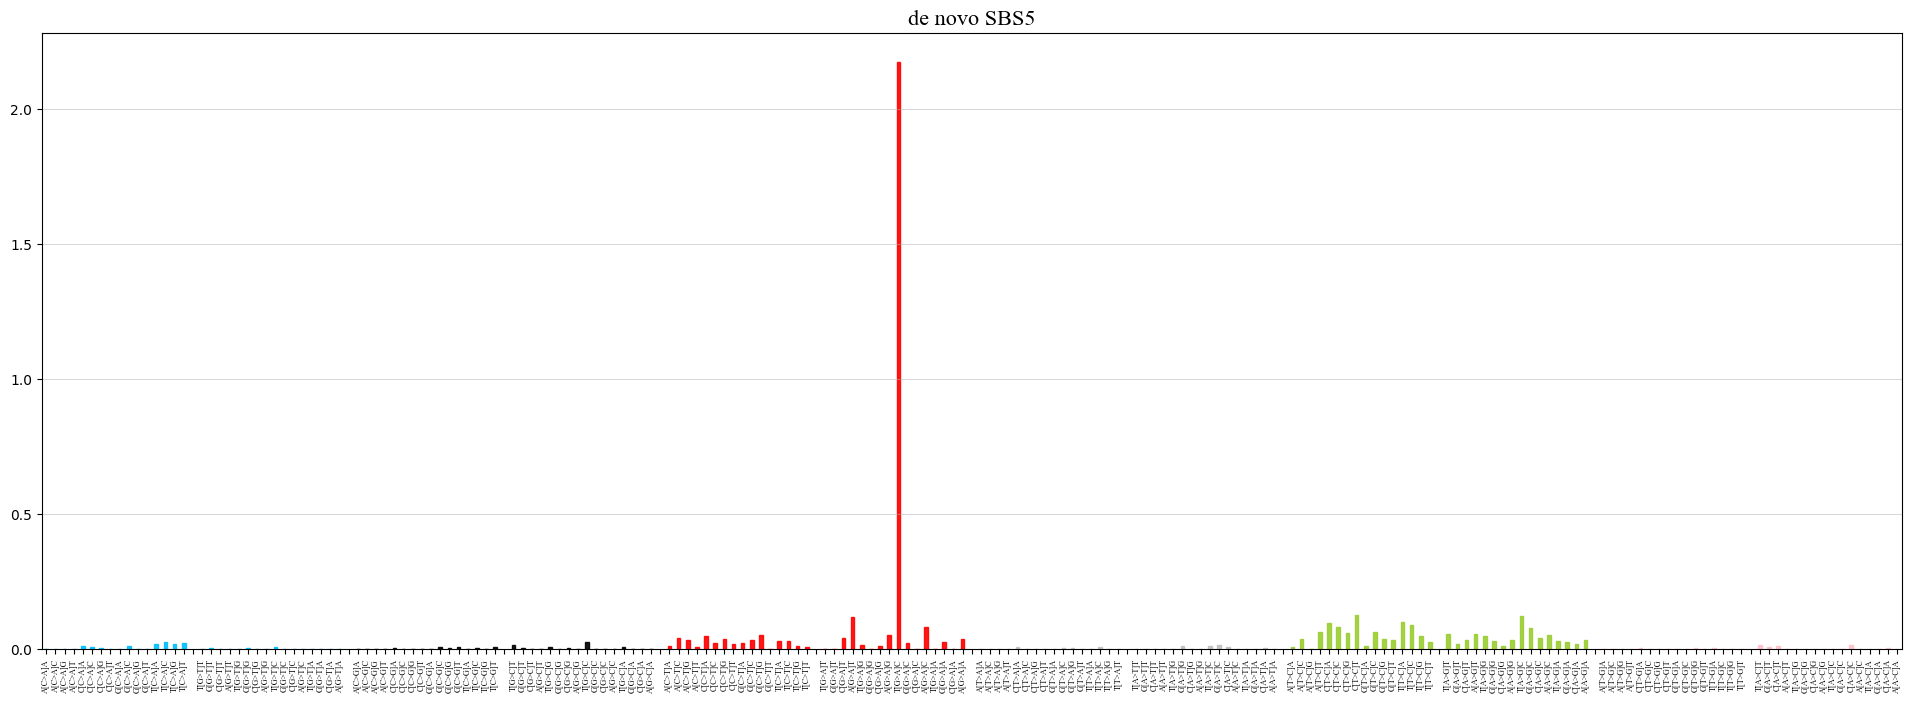

ncomp = 6, train cossim = 0.66, test cossim = 0.65


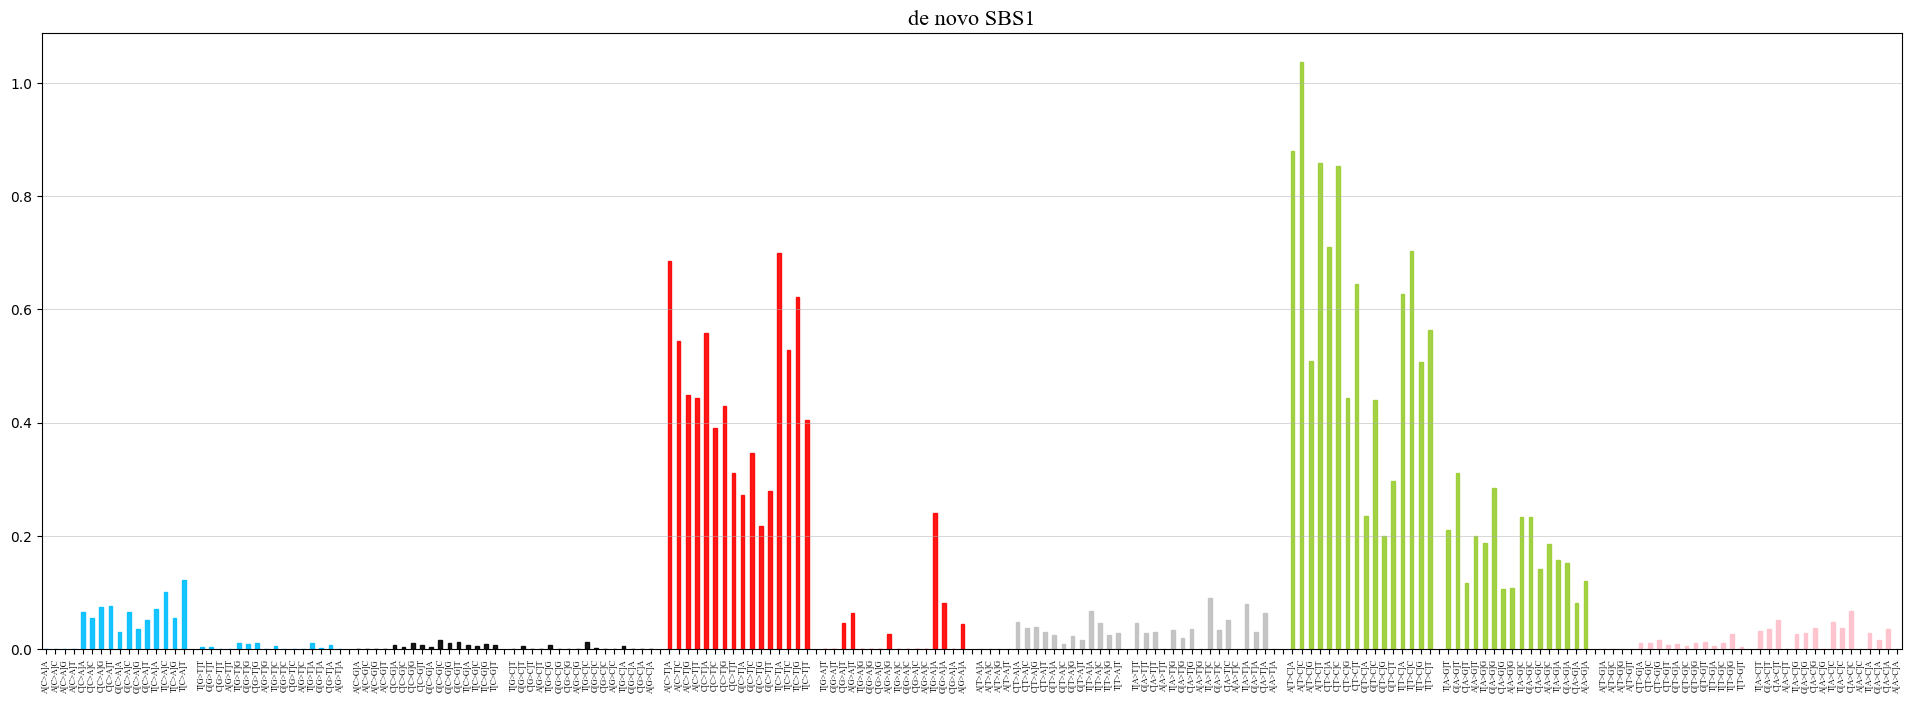

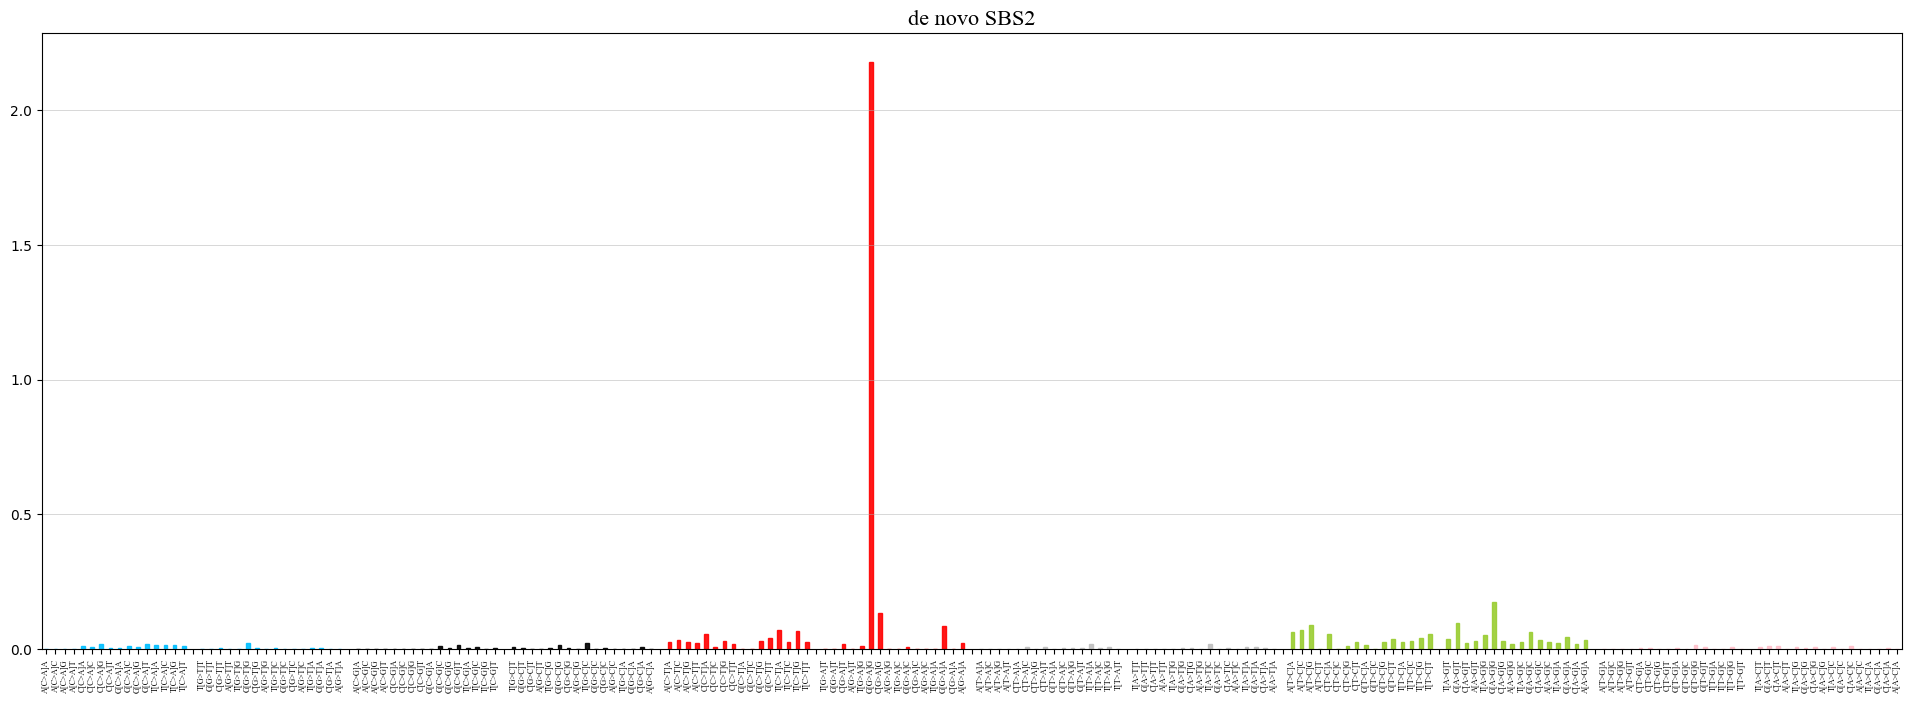

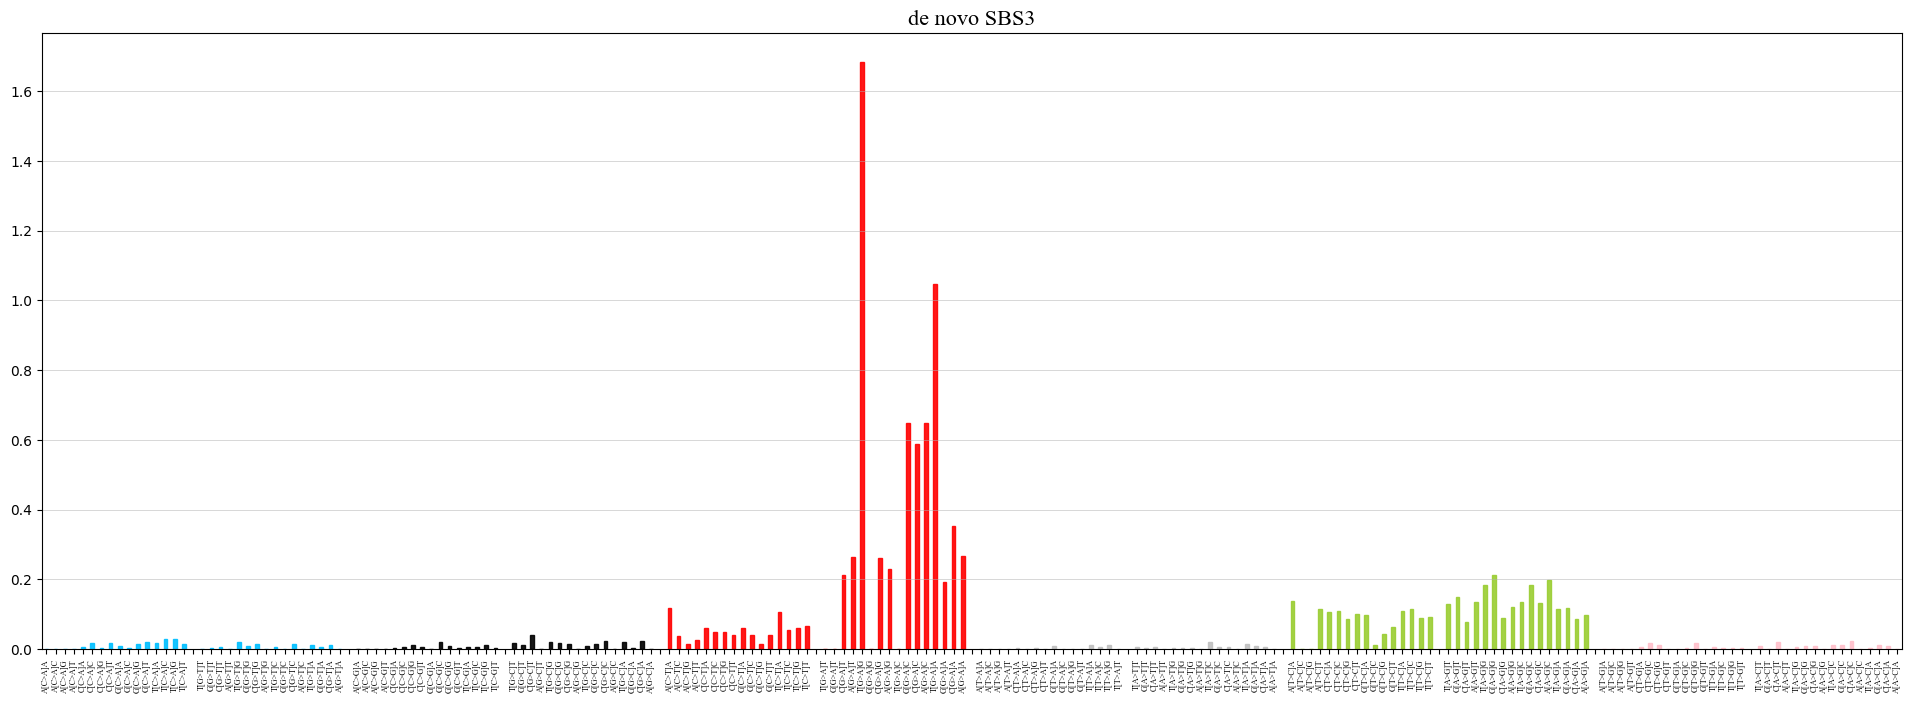

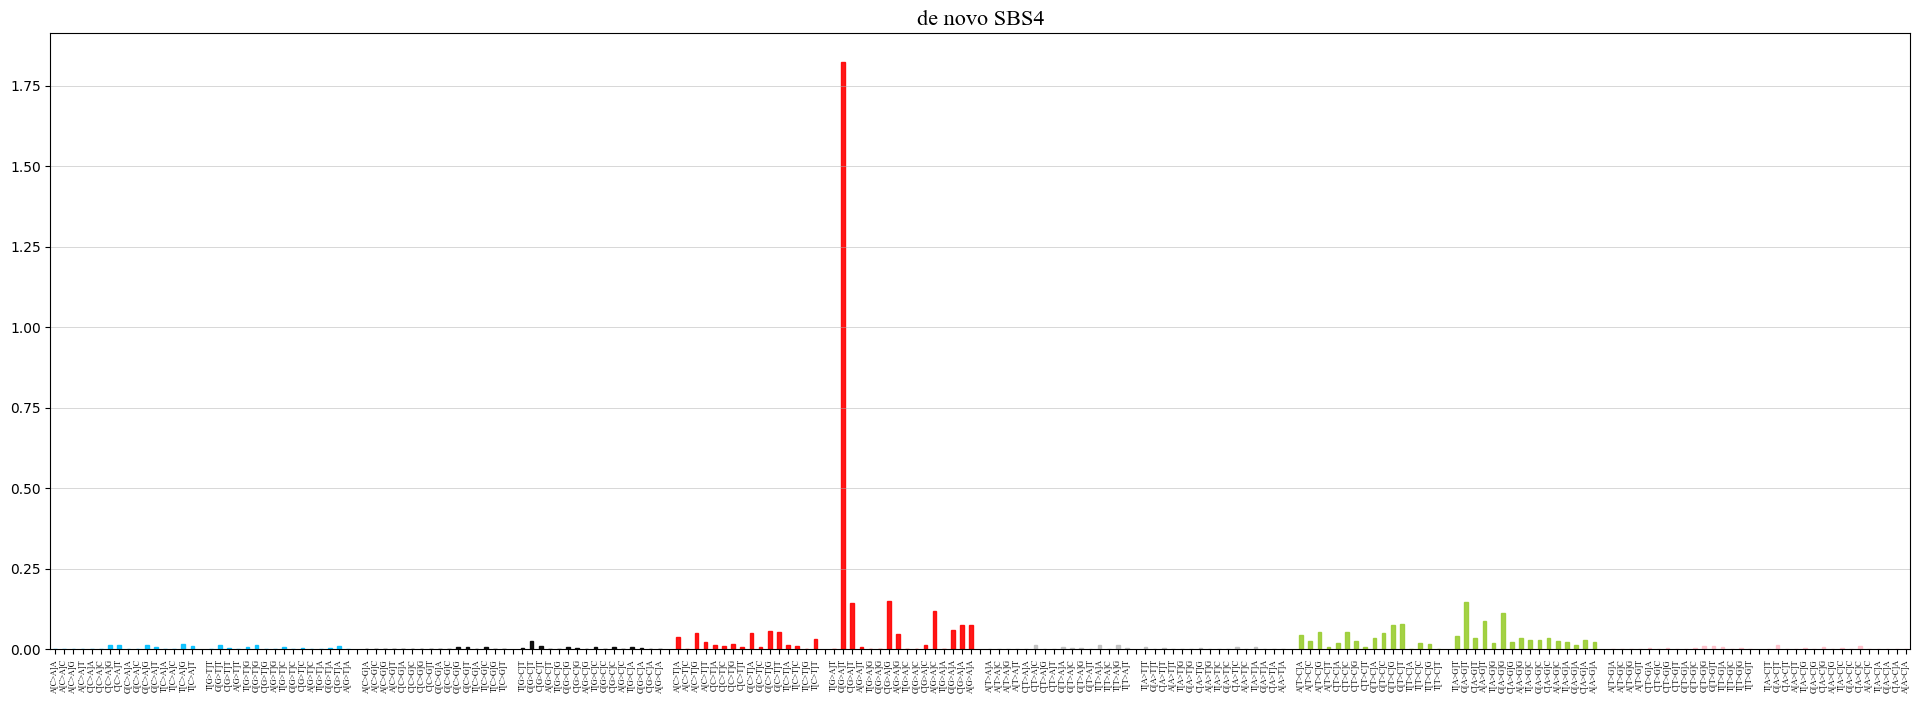

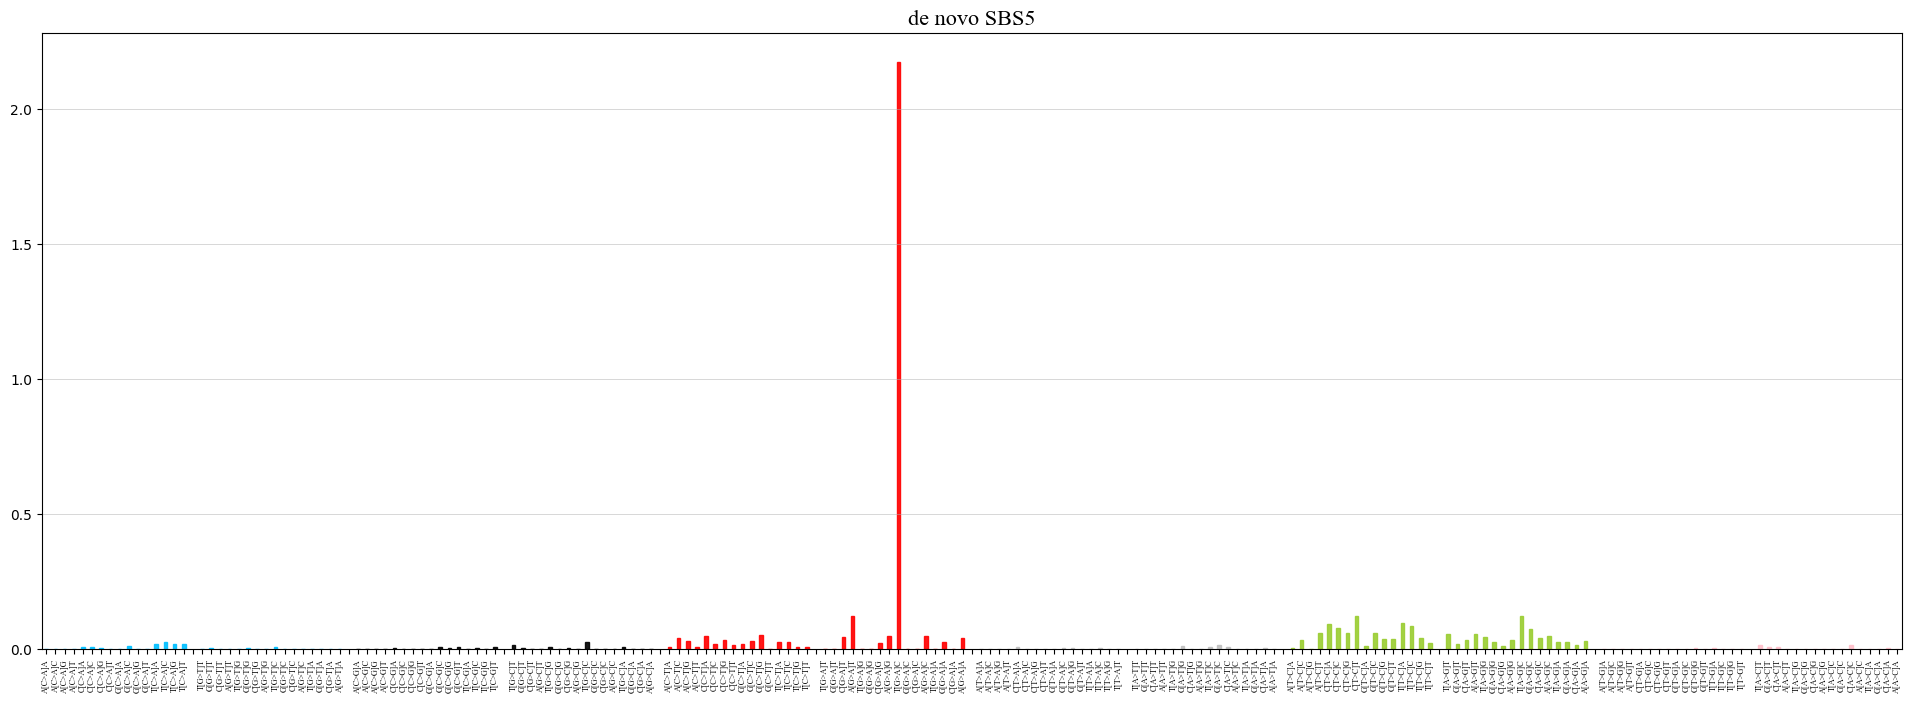

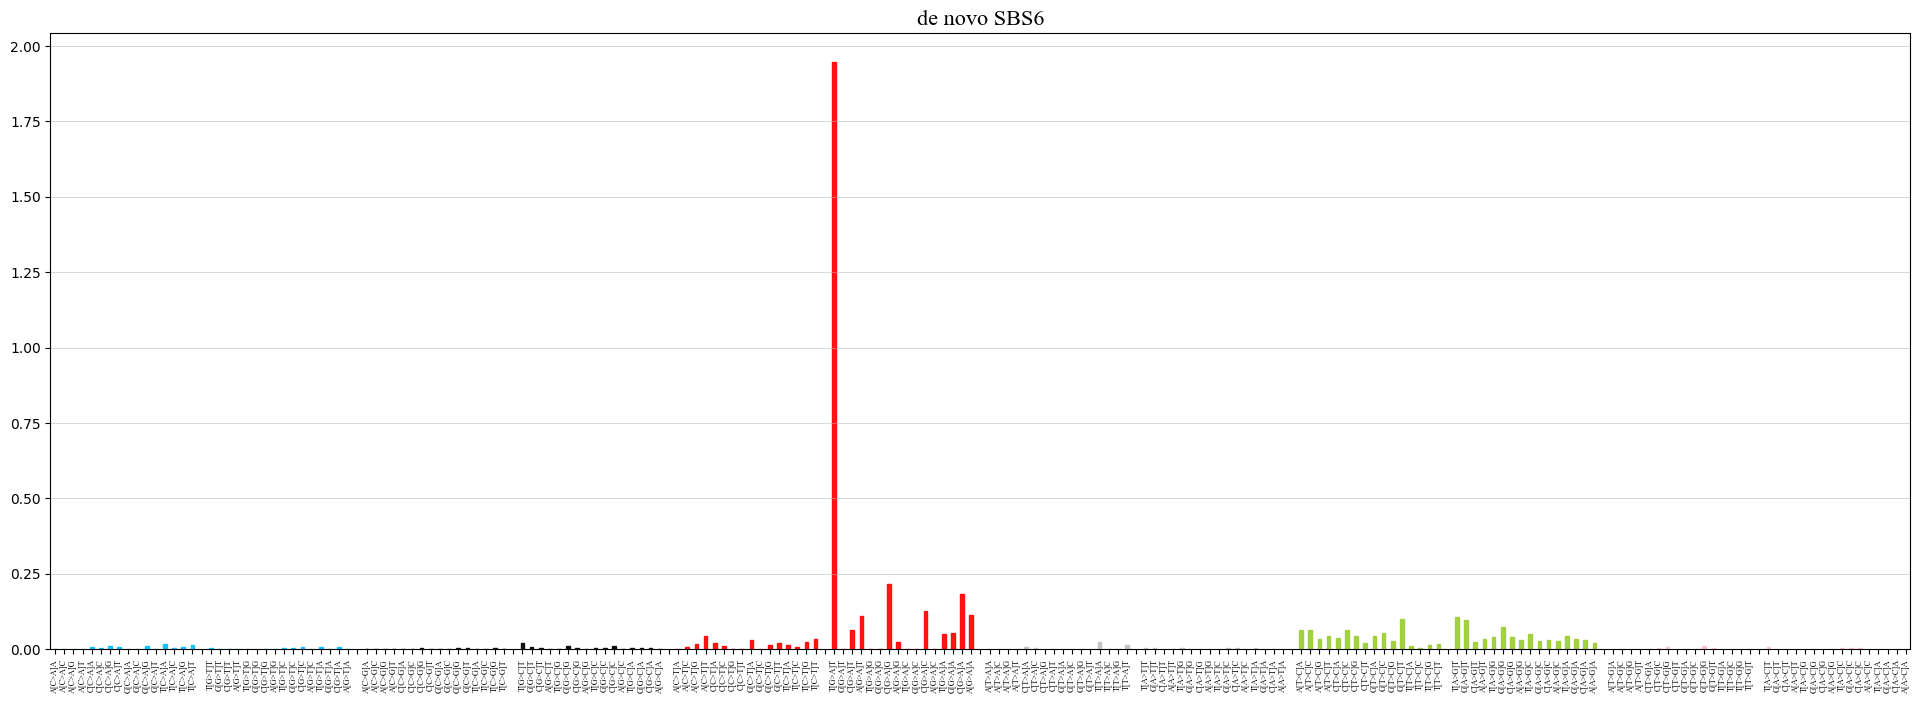

In [ ]:
# Example data matrix X (replace this with your actual data)
X = sp192.copy()

# Split the data into training and test sets
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Range of component numbers to try
component_range = range(1, 7)

# Test NMF with different numbers of components
for n_components in component_range:
    # Create and fit the NMF model to the training data
    model = NMF(n_components=n_components, random_state=42, max_iter=500)
    W = model.fit_transform(X_train)
    H = model.components_
    
    # Reconstruct the test data
    X_reconstructed = np.dot(W, H)
    rec_df_train = pd.DataFrame(X_reconstructed, index=X_train.index, columns=X_train.columns)
    
    X_reconstructed_test = model.inverse_transform(model.transform(X_test))
    rec_df_test = pd.DataFrame(X_reconstructed_test, index=X_test.index, columns=X_test.columns)

    # Calculate the reconstruction error on the test data
    cossims_train = get_cossim(X_train, rec_df_train)
    cossims_test = get_cossim(X_test, rec_df_test)

    print(f"ncomp = {n_components}, train cossim = {cossims_train.mean():.2f}, test cossim = {cossims_test.mean():.2f}")

    signatures = pd.DataFrame(H, columns=X_train.columns)
    for i in signatures.index:
        sign = signatures.loc[i].rename('MutSpec').reset_index()
        plot_mutspec192(sign, title=f'de novo SBS{i+1}');